In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [407]:
df = pd.read_csv('Taxi_Trips.csv',usecols=['Trip Start Timestamp','Trip Seconds','Trip Miles','Pickup Community Area' ,'Dropoff Community Area'])
df.dropna(subset=['Trip Start Timestamp','Pickup Community Area', 'Dropoff Community Area'],
          axis=0, # axis=0表示删除行；
          how='any', # how=any表示任意一个出现空值，就删掉该行
          inplace=True # inplace=True表示在原df上进行修改；
          )

df["start"]=df["Trip Start Timestamp"].map(lambda x:x.split(" ")[0])
df["start"]=pd.to_datetime(df["start"], format='%m/%d/%Y')
df["number of weeks"] =  df["start"].dt.isocalendar().week
df=df[['Trip Seconds',"Trip Miles","Pickup Community Area","Dropoff Community Area","start","number of weeks"]]

C:\Users\Huang\anaconda3\envs\aiauto\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [416]:
df["year"]=df["start"].dt.isocalendar().year
df["num_weeks"]=df["number of weeks"]+(df["year"]-2019)*52
count=df['num_weeks'].value_counts()
x=list(range(1,201))
count_week=[]
for i in range(1,201):
    count_week.append(count[i])

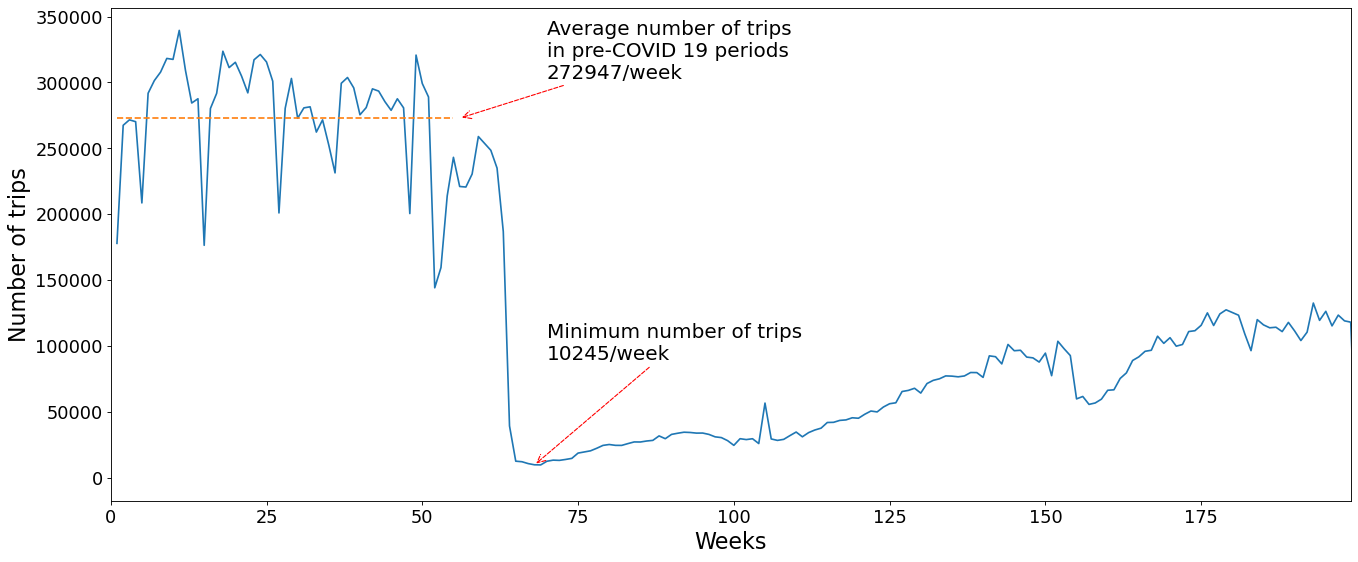

In [545]:
average_trips=np.mean(count_week[:60])
bottom=np.min(count_week[60:75])
for i in range(60,76):
    if count_week[i]==bottom:
        bottom_week=i
plt.figure(figsize=(20,8),dpi=80)
plt.plot(x,count_week)
plt.annotate("Minimum number of trips \n%.5s/week"%bottom, xy = (bottom_week, bottom), xytext= (70, 90000),color = "k", fontsize=18,arrowprops = dict(arrowstyle="->",linestyle="--",color = "r"))
plt.annotate("Average number of trips \nin pre-COVID 19 periods \n%.6s/week"%average_trips, xy = (56, average_trips), xytext= (70, average_trips+30000),color = "k", fontsize=18,arrowprops = dict(arrowstyle="->",linestyle="--",color = "r"))
plt.plot(list(range(1,56)),np.ones(55)*average_trips,linestyle="--")
plt.xlim(0,199)
#plt.title('OD demand for Chicago taxi trips per week ',fontsize=16,fontweight='bold')
plt.xlabel('Weeks',fontsize=20)
plt.ylabel('Number of trips',fontsize=20)
plt.tick_params(labelsize=16)

    

In [4]:
count_area=df['Dropoff Community Area'].groupby(df['Pickup Community Area']).value_counts()

od_list=[] 
for i in range(1,78):
    for j in range(1,78):
        if (i,j) in count_area.index:
            if (count_area[i,j]>10000): #Filter out the OD pairs with the number of trips bigger than 10000
                od_list.append((i,j))


In [5]:
odtrips=[] 
max_weeks=max(df['num_weeks'])
for i in range(0,len(od_list)):   
    df_area=df[(df["Pickup Community Area"]==od_list[i][0])&(df["Dropoff Community Area"]==od_list[i][1])]
    count_area=df_area['num_weeks'].value_counts()
    #array=np.zeros(len(count_area))
    for j in range(1,max_weeks+1):
        if j in count_area.index:
            #array[j-1]=count_area[j]
            odtrips.append(count_area[j])
        else:
            odtrips.append(0)

s=int(len(odtrips)/max_weeks)
odtrips = np.mat(odtrips).reshape(s,max_weeks)
odtrips = np.array(odtrips)

#Normalization
odtrips=(odtrips-np.min(odtrips))/(np.max(odtrips)-np.min(odtrips))
odtrips #size 182x200

array([[0.00645928, 0.00831713, 0.00864118, ..., 0.00216029, 0.0021819 ,
        0.        ],
       [0.00326204, 0.00308922, 0.00330525, ..., 0.00116656, 0.00097213,
        0.        ],
       [0.00216029, 0.0014906 , 0.00190106, ..., 0.00090732, 0.00103694,
        0.        ],
       ...,
       [0.00321884, 0.00451501, 0.00479585, ..., 0.00362929, 0.00384532,
        0.        ],
       [0.00198747, 0.00317563, 0.00306762, ..., 0.002938  , 0.00224671,
        0.        ],
       [0.0147116 , 0.01777922, 0.01516526, ..., 0.00680493, 0.00652409,
        0.        ]])

In [6]:
import sys
from clustering import DTWClustering
from sklearn.model_selection import train_test_split
%matplotlib inline

In [7]:
data_train, data_test=train_test_split(odtrips,test_size=0.2,random_state=12)#80% train dataset and 20% test dataset
train_before=data_train[:,:60] #Before the Resistance
train_after=data_train[:,60:201] #After the Resistance
test_before=data_test[:,:60]  #Before the Resistance
test_after=data_test[:,60:201] #After the Resistance

In [8]:
model = DTWClustering(data_train, 5)
model.train()

0.0008809000000269407 queue placement complete
44.07628600000004 computations complete
44.077002900000025 iteration complete
0.0005979000000024826 queue placement complete
42.23525380000001 computations complete
42.23611729999999 iteration complete
0.0004352000000267253 queue placement complete
45.32057980000002 computations complete
45.321323500000005 iteration complete
0.00035689999998567146 queue placement complete
45.072289599999976 computations complete
45.07356400000003 iteration complete
0.00036399999999048305 queue placement complete
43.090609900000004 computations complete
43.091589699999986 iteration complete
0.0005085000000235596 queue placement complete
41.98625920000006 computations complete
41.98762440000007 iteration complete
0.00039709999998649437 queue placement complete
45.40772399999992 computations complete
45.408490599999936 iteration complete
0.0010223000000451066 queue placement complete
51.813856100000066 computations complete
51.81523600000003 iteration complet

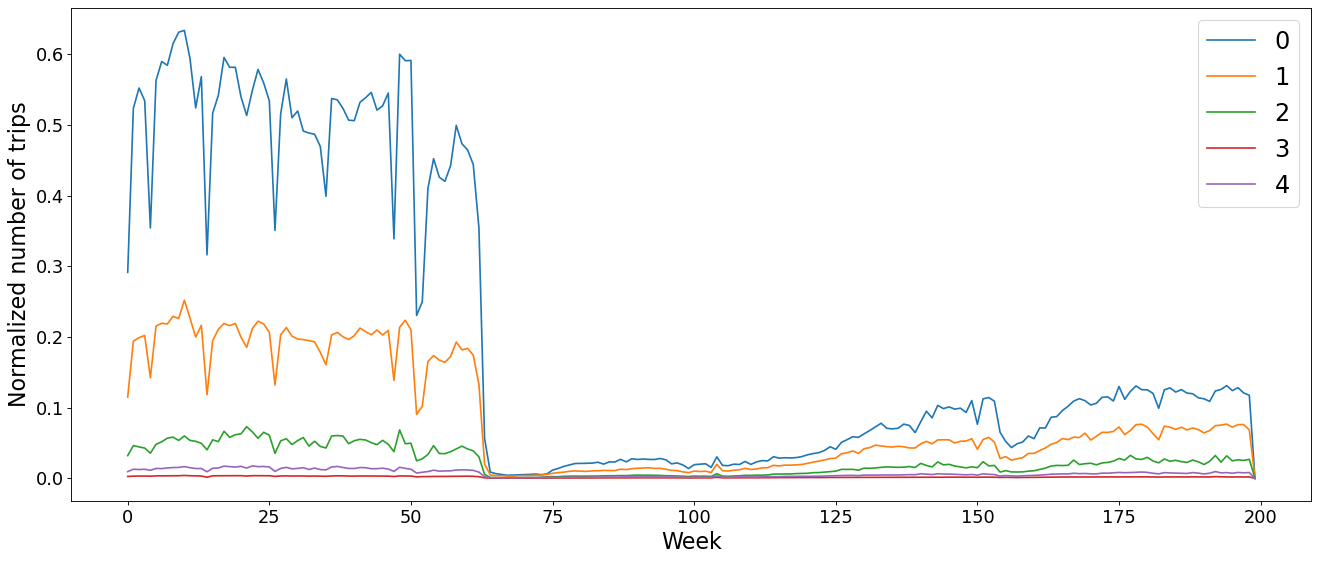

In [547]:
plt.figure(figsize=(20,8),dpi=80)
i=0
for centroid in model.centroids:  
    plt.plot(np.arange(len(centroid)), centroid,label=i)
    plt.xlabel('Week',fontsize=20)
    plt.ylabel('Normalized number of trips',fontsize=20)
    i=i+1
plt.legend(fontsize="large") 
plt.tick_params(labelsize=16)

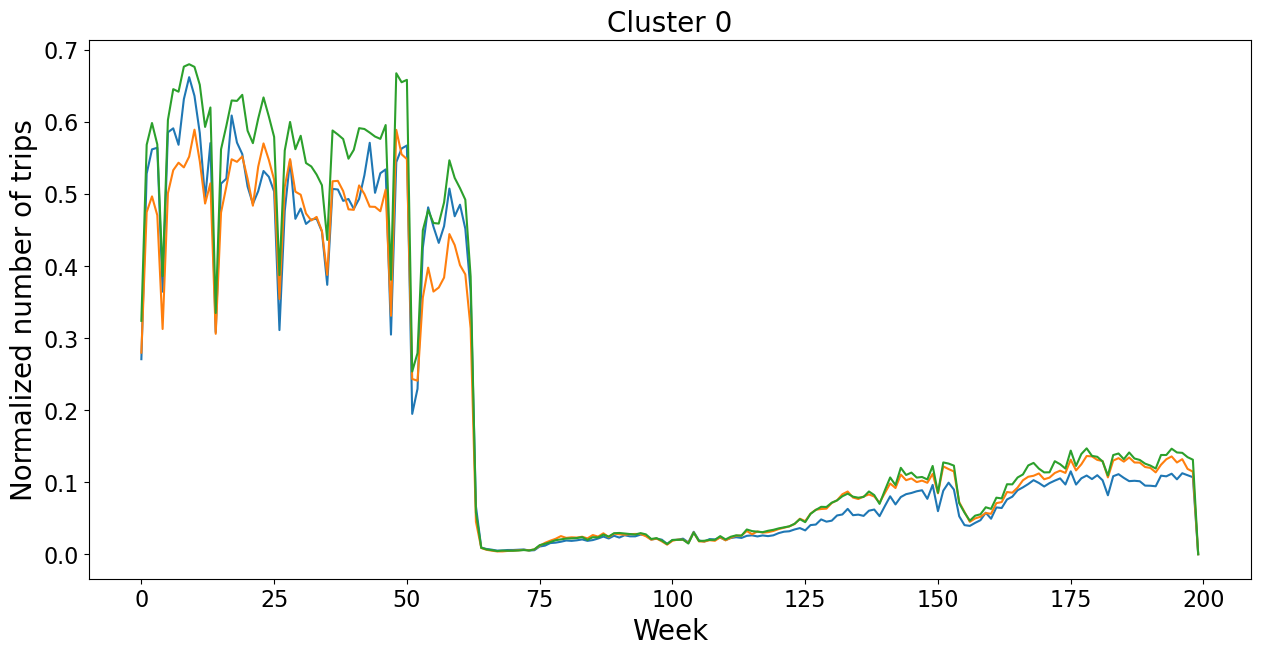

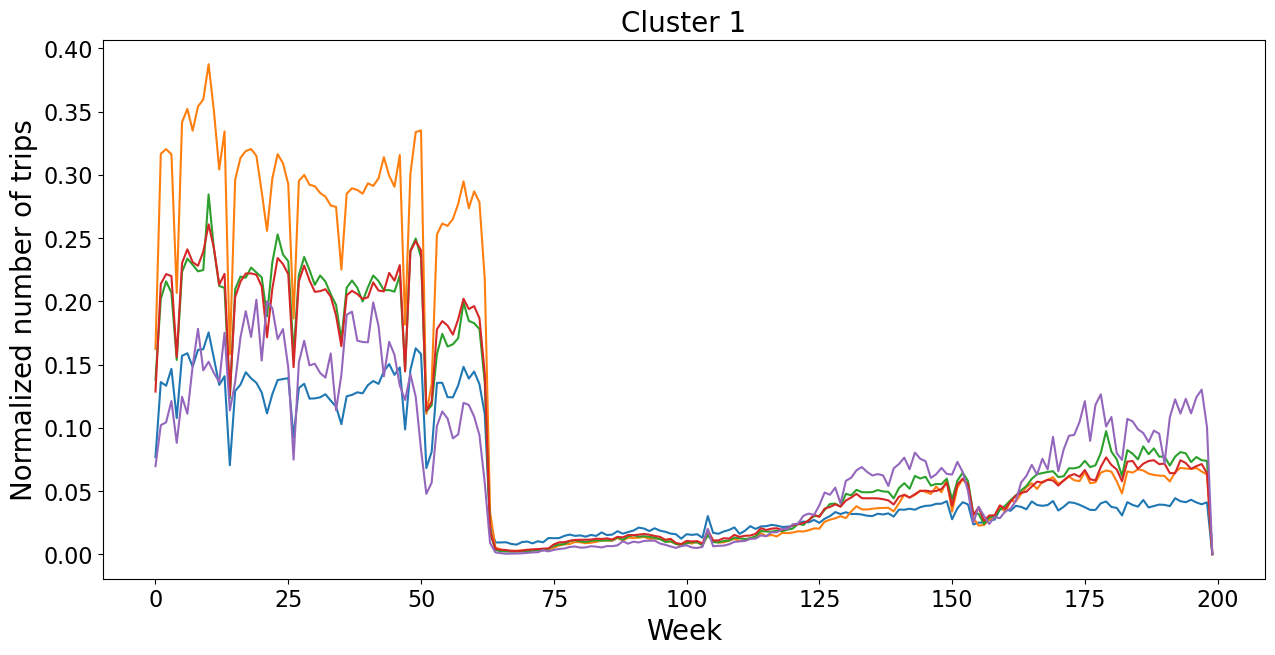

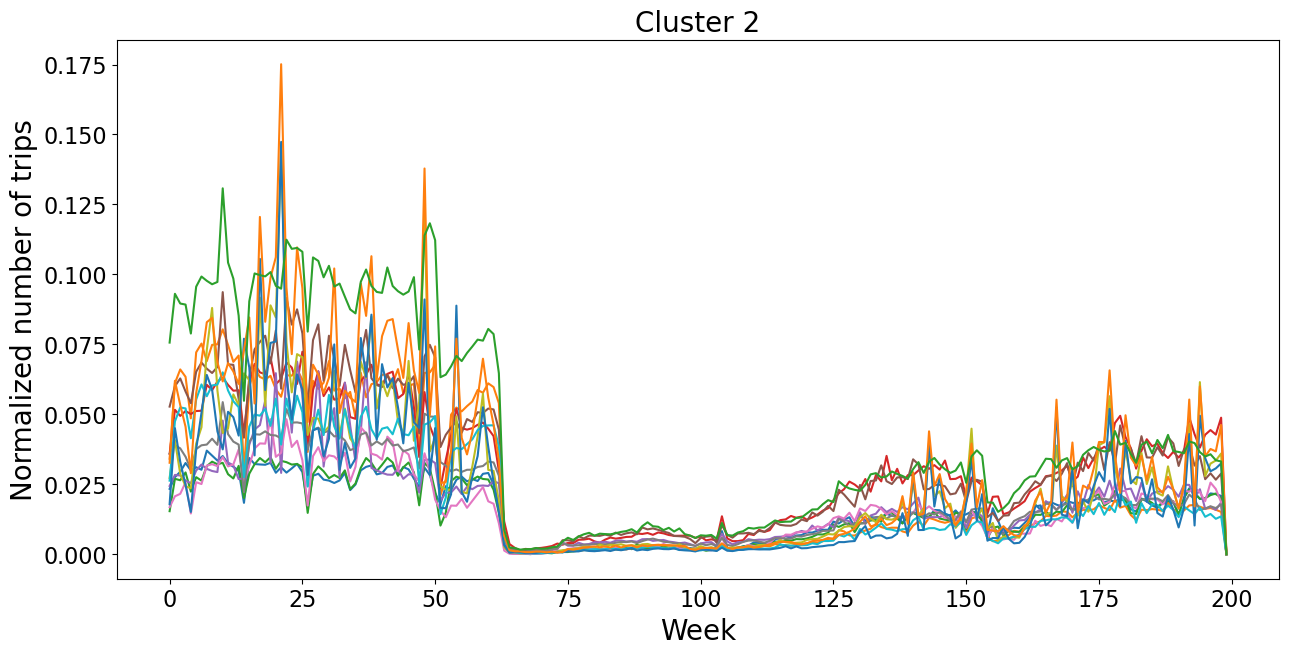

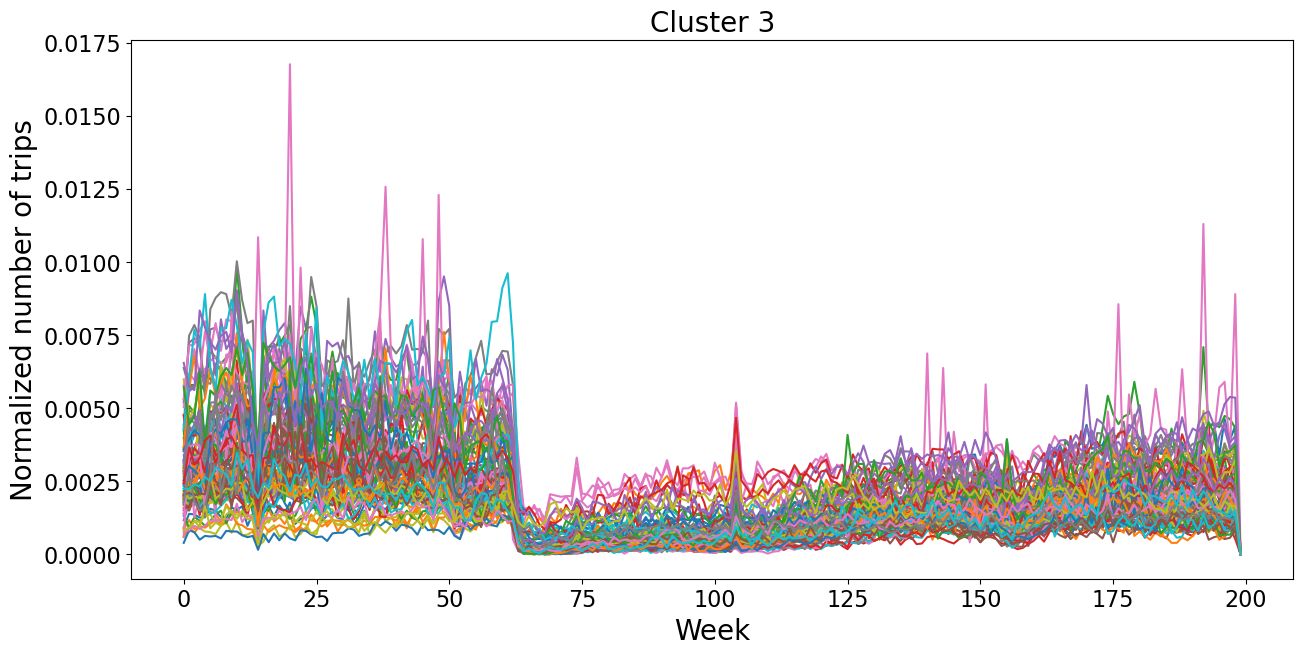

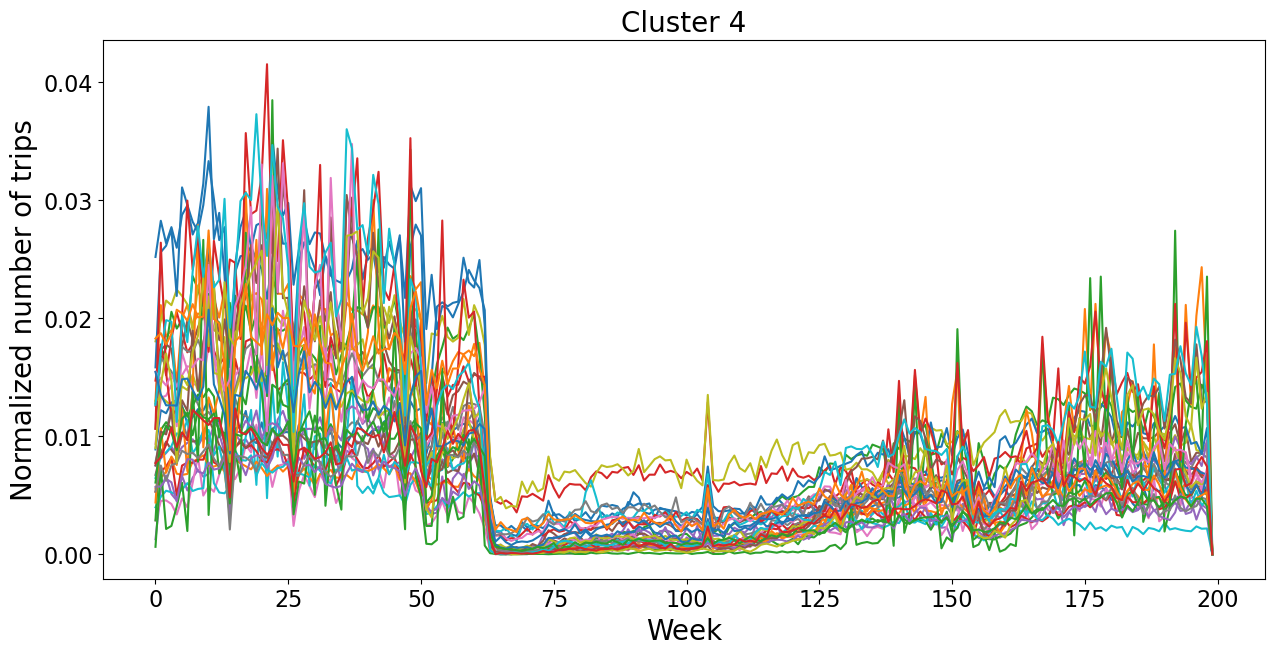

In [548]:
for j in range (5):
    plt.figure(figsize=(15,7))
    for i in model.clusters[j]:
        plt.title("Cluster %d"%j,fontsize=20)
        plt.xlabel('Week',fontsize=20)
        plt.ylabel('Normalized number of trips',fontsize=20)
        plt.plot(np.arange(len(data_train[i])),data_train[i]) 
        plt.tick_params(labelsize=16)

In [11]:
cluster_0=[]
cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]

for i in range(len(data_test)):
    if model.predict(data_test[i])[1]==0:
        cluster_0.append(i)
    elif model.predict(data_test[i])[1]==1:
        cluster_1.append(i)
    elif model.predict(data_test[i])[1]==2:
        cluster_2.append(i)
    elif model.predict(data_test[i])[1]==3:
        cluster_3.append(i)
    else:
        cluster_4.append(i)

In [482]:
model.clusters[0]

[86, 99, 117]

In [459]:
from geopandas import GeoDataFrame
from shapely.geometry import Point,Polygon
#from contextily import add_basemap

import geopandas as gpd
import descartes
%matplotlib inline

##### Build a resilience model separately for a single cluster with train dataset

In [225]:
import torch
from scipy.optimize import curve_fit
from torch.optim import Adam
from torch import optim
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import r2_score #R_2

In [13]:
def func(x,a,b,c,d):
    y=d/(1+torch.exp(a+b*x)+c)
    return y

In [14]:
#According to the epidemic prevention policy, the time interval is divided into six periods
#[59,69],[69,94],[94,99],[99,151],[151,157],[157,180]
time_interval=[[59,69],[69,94],[94,99],[99,151],[151,157],[157,180]]

## Cluster0

In [559]:
n=len(model.clusters[0])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[0]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)

Text(0.5, 0, 'weeks')

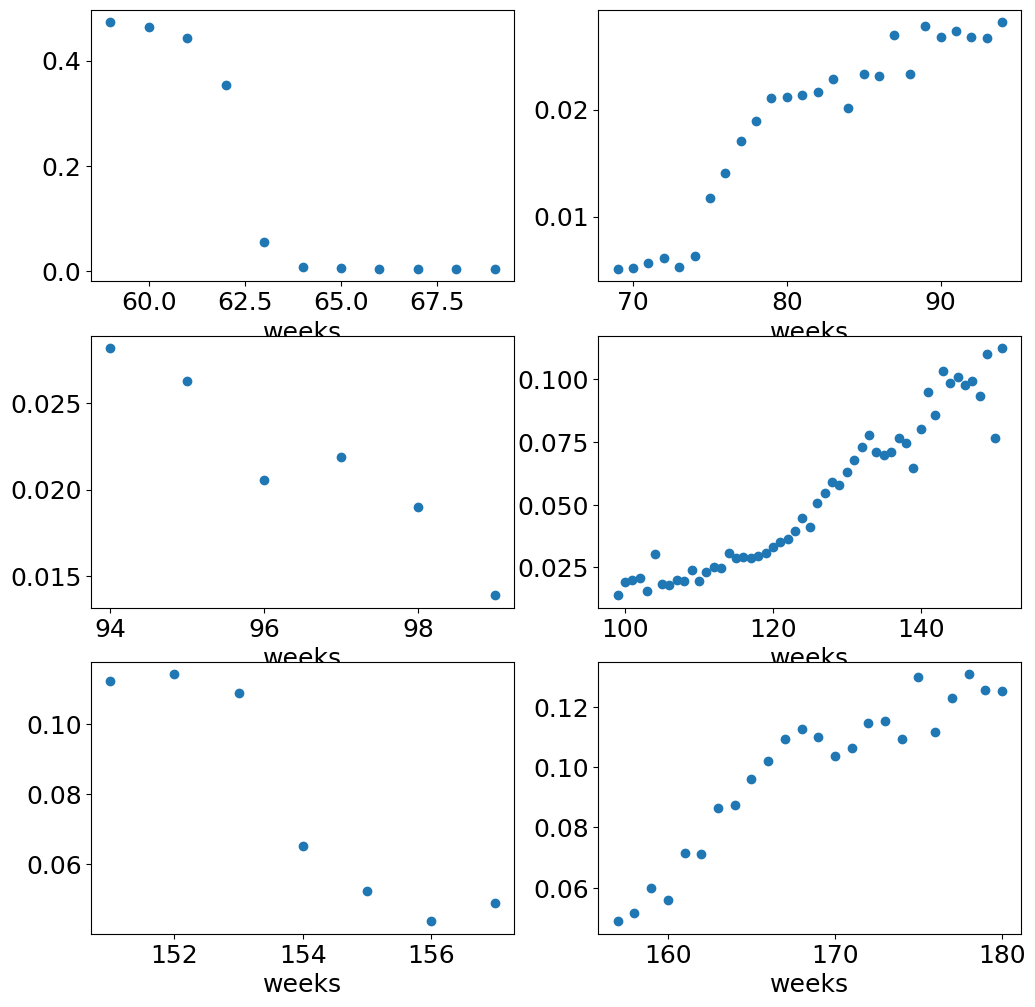

In [560]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(xdays[0], yorigin[0])
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(xdays[1], yorigin[1])
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(xdays[2], yorigin[2])
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(xdays[3], yorigin[3])
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(xdays[4], yorigin[4])
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(xdays[5], yorigin[5])
plt.xlabel('weeks')

In [561]:
normality=np.zeros([1,60])
for i in model.clusters[0]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[0]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

In [562]:
for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))


Text(0.5, 0, 'weeks')

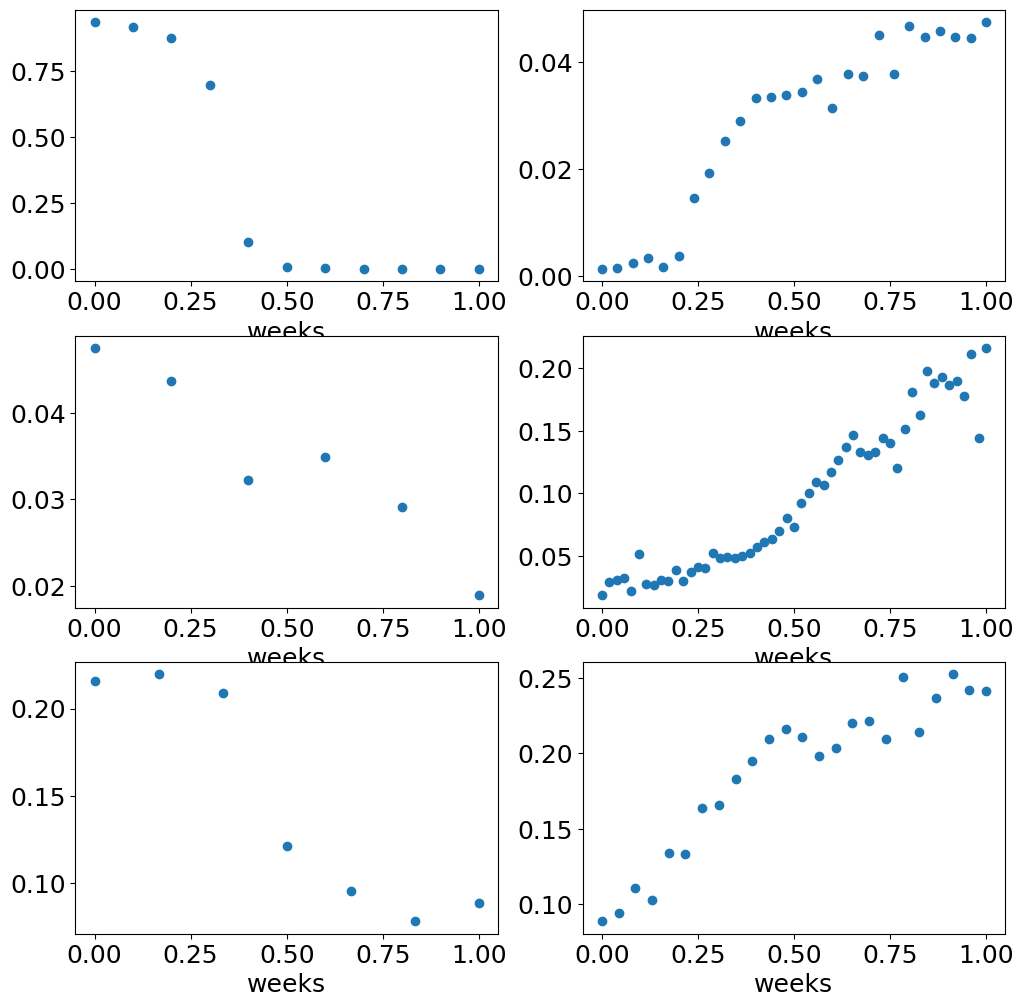

In [563]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0])
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1])
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2])
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3])
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4])
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5])
plt.xlabel('weeks')


In [564]:
parameter0=[]
predict_param0=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.002)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(20000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter0.append(params)
    predict_param0.append(pre_y)

0
step=0 loss=0.31939
step=1000 loss=0.03739
step=2000 loss=0.03335
step=3000 loss=0.02778
step=4000 loss=0.02198
step=5000 loss=0.01711
step=6000 loss=0.01393
step=7000 loss=0.01129
step=8000 loss=0.00915
step=9000 loss=0.00741
step=10000 loss=0.00600
step=11000 loss=0.00506
step=12000 loss=0.00424
step=13000 loss=0.00354
step=14000 loss=0.00294
step=15000 loss=0.00243
step=16000 loss=0.00208
step=17000 loss=0.00176
step=18000 loss=0.00149
step=19000 loss=0.00125
1
step=0 loss=0.28361
step=1000 loss=0.00024
step=2000 loss=0.00024
step=3000 loss=0.00024
step=4000 loss=0.00023
step=5000 loss=0.00023
step=6000 loss=0.00022
step=7000 loss=0.00021
step=8000 loss=0.00018
step=9000 loss=0.00009
step=10000 loss=0.00005
step=11000 loss=0.00005
step=12000 loss=0.00004
step=13000 loss=0.00003
step=14000 loss=0.00003
step=15000 loss=0.00002
step=16000 loss=0.00002
step=17000 loss=0.00002
step=18000 loss=0.00002
step=19000 loss=0.00002
2
step=0 loss=0.07870
step=1000 loss=0.00002
step=2000 loss=0.

Text(0.5, 0, 'weeks')

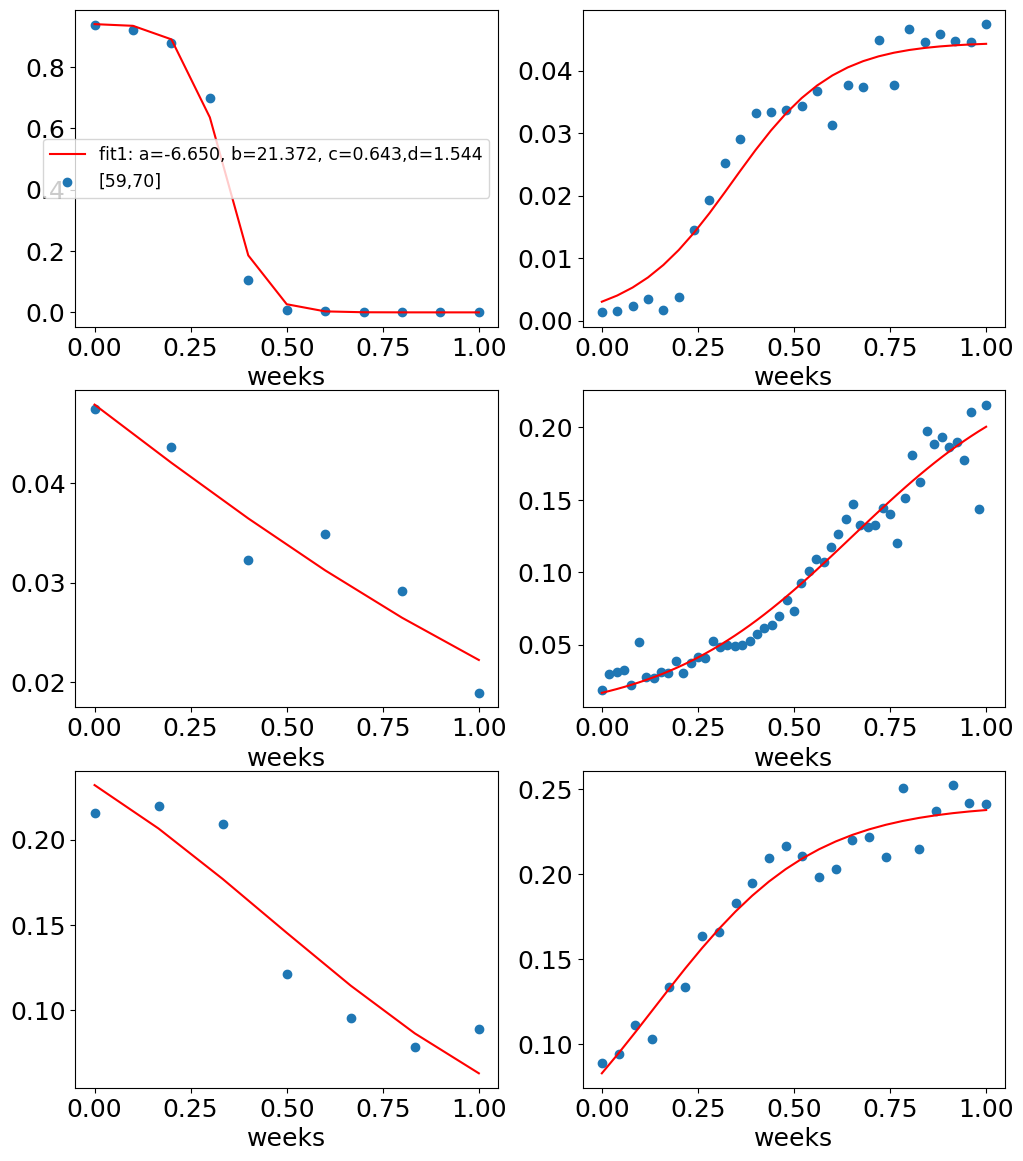

In [581]:
fig, ax = plt.subplots(3,2, figsize=(12,14))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict_param0[0].detach().numpy(), 'r-')

plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict_param0[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict_param0[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict_param0[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict_param0[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict_param0[5].detach().numpy(), 'r-')
plt.xlabel('weeks')



#### data recovery

In [571]:
y_predict=[]
for i in range(len(time_interval)):
    pre_y=predict_param0[i]*(average_normality-min_trips)+min_trips
    y_predict.append(pre_y)

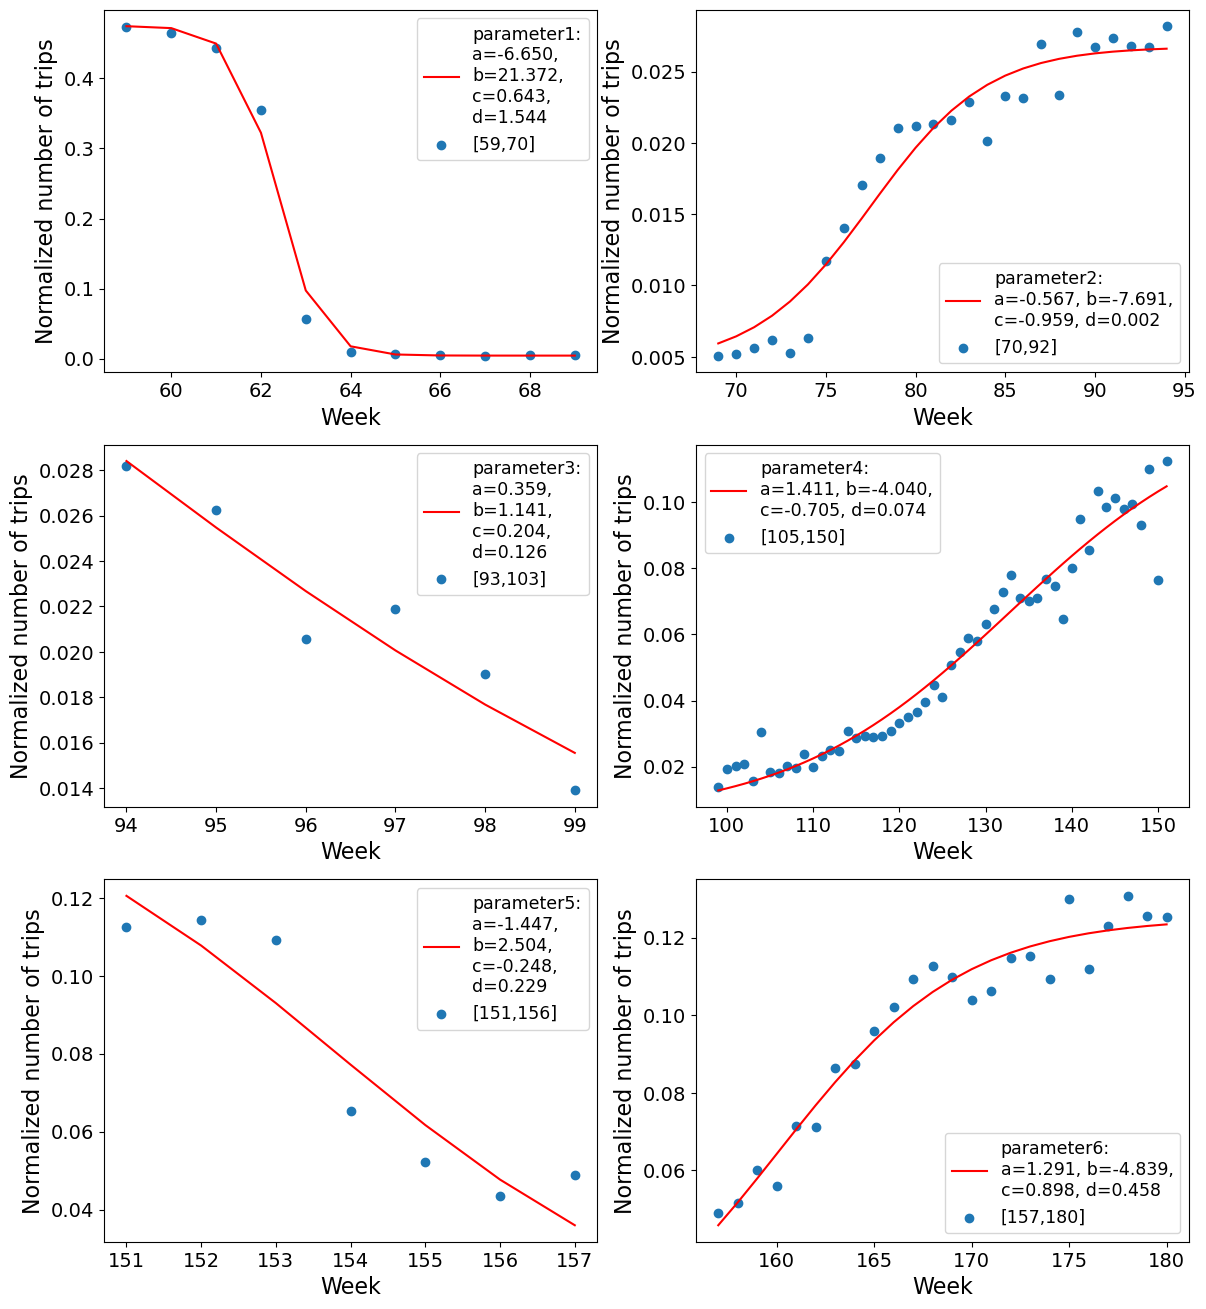

In [592]:
fig, ax = plt.subplots(3,2, figsize=(14,16))
plt.subplot(3,2,1)
plt.scatter(xdays[0], yorigin[0], label='[59,70]')
plt.plot(xdays[0], y_predict[0].detach().numpy(), 'r-',label='parameter1:\na=%5.3f,\nb=%5.3f,\nc=%5.3f,\nd=%5.3f' % tuple(parameter0[0]))
plt.xlabel('Week',fontsize=16)
plt.ylabel('Normalized number of trips',fontsize=16)
plt.legend(fontsize="x-small")
plt.tick_params(labelsize=14)
plt.subplot(3,2,2)
plt.scatter(xdays[1], yorigin[1], label='[70,92]')
plt.plot(xdays[1], y_predict[1].detach().numpy(), 'r-',label='parameter2:\na=%5.3f, b=%5.3f,\nc=%5.3f, d=%5.3f' % tuple(parameter0[1]))
plt.xlabel('Week',fontsize=16)
plt.ylabel('Normalized number of trips',fontsize=16)
plt.legend(fontsize="x-small")
plt.tick_params(labelsize=14)
plt.subplot(3,2,3)
plt.scatter(xdays[2], yorigin[2], label='[93,103]')
plt.plot(xdays[2], y_predict[2].detach().numpy(), 'r-',label='parameter3:\na=%5.3f,\nb=%5.3f,\nc=%5.3f,\nd=%5.3f' % tuple(parameter0[2]))
plt.xlabel('Week',fontsize=16)
plt.ylabel('Normalized number of trips',fontsize=16)
plt.legend(fontsize="x-small")
plt.tick_params(labelsize=14)
plt.subplot(3,2,4)
plt.scatter(xdays[3], yorigin[3], label='[105,150]')
plt.plot(xdays[3], y_predict[3].detach().numpy(), 'r-',label='parameter4:\na=%5.3f, b=%5.3f,\nc=%5.3f, d=%5.3f' % tuple(parameter0[3]))
plt.xlabel('Week',fontsize=16)
plt.ylabel('Normalized number of trips',fontsize=16)
plt.legend(fontsize="x-small")
plt.tick_params(labelsize=14)
plt.subplot(3,2,5)
plt.scatter(xdays[4], yorigin[4], label='[151,156]')
plt.plot(xdays[4], y_predict[4].detach().numpy(), 'r-',label='parameter5:\na=%5.3f,\nb=%5.3f,\nc=%5.3f,\nd=%5.3f' % tuple(parameter0[4]))
plt.xlabel('Week',fontsize=16)
plt.ylabel('Normalized number of trips',fontsize=16)
plt.legend(fontsize="x-small")
plt.tick_params(labelsize=14)
plt.subplot(3,2,6)
plt.scatter(xdays[5], yorigin[5], label='[157,180]')
plt.plot(xdays[5], y_predict[5].detach().numpy(), 'r-',label='parameter6:\na=%5.3f, b=%5.3f,\nc=%5.3f, d=%5.3f' % tuple(parameter0[5]))
plt.xlabel('Week',fontsize=16)
plt.ylabel('Normalized number of trips',fontsize=16)
plt.legend(fontsize="x-small")
plt.tick_params(labelsize=14)

## Predict

In [111]:
cluster_0

[9]

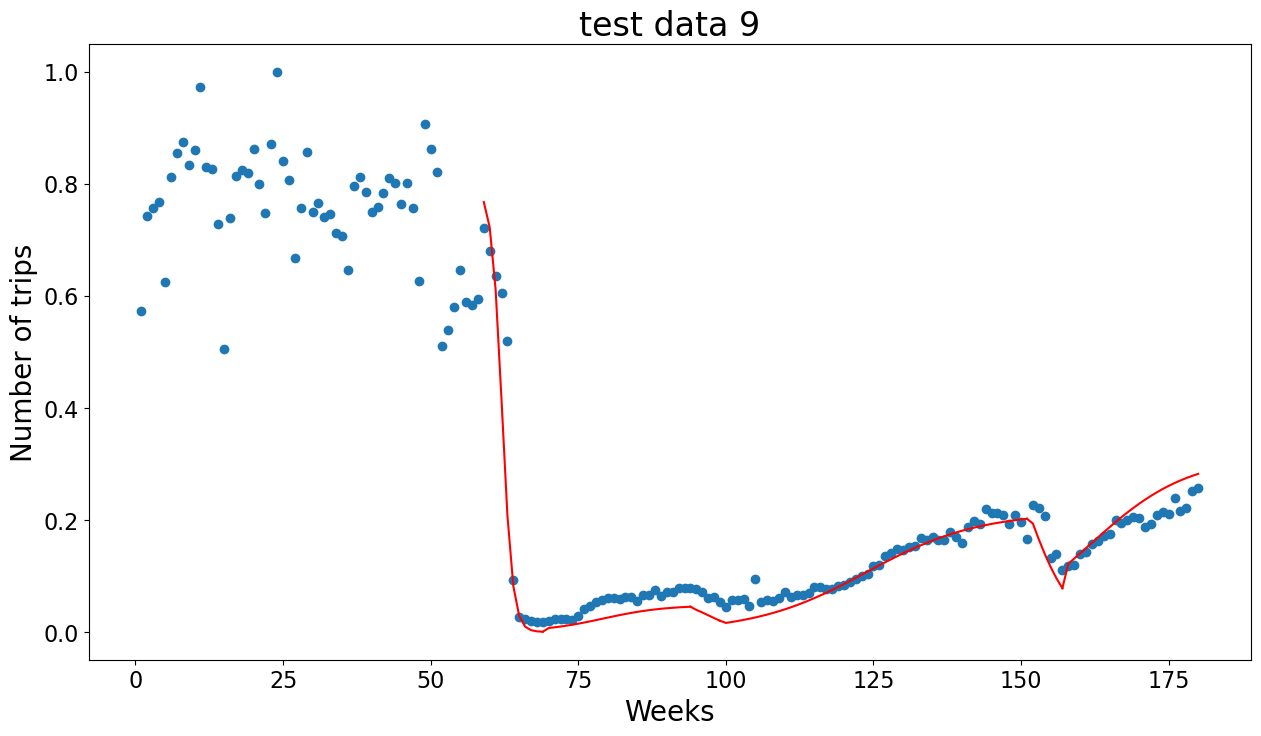

In [533]:
fig, ax = plt.subplots(len(cluster_0),1, figsize=(15,8))
MSE_0=[]
R2_0=[]
for k in range(len(cluster_0)):
    predict0=[]
    pre_0=[]
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        y=data_test[cluster_0[k]][a:b+1]
        pre_y=predict_param0[i]*(np.mean(test_before[cluster_0[k]])-min_trips)+min_trips
        if i>0:
            pre_y[0]=predict0[i-1][-1]
        predict0.append(pre_y)
        pre_0=pre_0+pre_y.detach().numpy().tolist()[:(b-a)]
    MSE=mean_squared_error(data_test[cluster_0[k]][59:180],pre_0)*1e5
    r2=r2_score(data_test[cluster_0[k]][59:180],pre_0)
    MSE_0.append(MSE)
    R2_0.append(r2)
    plt.subplot(len(cluster_0),1,k+1)
    plt.scatter(np.linspace(1, 180,180), data_test[cluster_0[k]][:180],label='real_data')
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        plt.plot(np.linspace(a, b,b-a+1), predict0[i].detach().numpy(),'r')
    plt.xlabel('Weeks',fontsize=20)
    plt.ylabel('Number of trips',fontsize=20)
    plt.title("test data %s"%cluster_0[k],fontsize=24)
    plt.tick_params(labelsize=16)
    plt.savefig('./cluster0_pre.png')

## Cluster1

In [295]:
n=len(model.clusters[1])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[1]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)

In [296]:
normality=np.zeros([1,60])
for i in model.clusters[1]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[1]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))

In [297]:
parameter1=[]
predict_param1=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.0012)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(15000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter1.append(params)
    predict_param1.append(pre_y)

0
step=0 loss=0.19428
step=1000 loss=0.09883
step=2000 loss=0.03601
step=3000 loss=0.03354
step=4000 loss=0.03047
step=5000 loss=0.02649
step=6000 loss=0.02313
step=7000 loss=0.01999
step=8000 loss=0.01723
step=9000 loss=0.01485
step=10000 loss=0.01281
step=11000 loss=0.01138
step=12000 loss=0.01009
step=13000 loss=0.00894
step=14000 loss=0.00793
1
step=0 loss=0.02183
step=1000 loss=0.00033
step=2000 loss=0.00030
step=3000 loss=0.00026
step=4000 loss=0.00021
step=5000 loss=0.00016
step=6000 loss=0.00010
step=7000 loss=0.00005
step=8000 loss=0.00004
step=9000 loss=0.00004
step=10000 loss=0.00003
step=11000 loss=0.00003
step=12000 loss=0.00003
step=13000 loss=0.00002
step=14000 loss=0.00002
2
step=0 loss=0.23479
step=1000 loss=0.00387
step=2000 loss=0.00007
step=3000 loss=0.00005
step=4000 loss=0.00005
step=5000 loss=0.00005
step=6000 loss=0.00004
step=7000 loss=0.00003
step=8000 loss=0.00002
step=9000 loss=0.00001
step=10000 loss=0.00000
step=11000 loss=0.00000
step=12000 loss=0.00000
s

Text(0.5, 0, 'weeks')

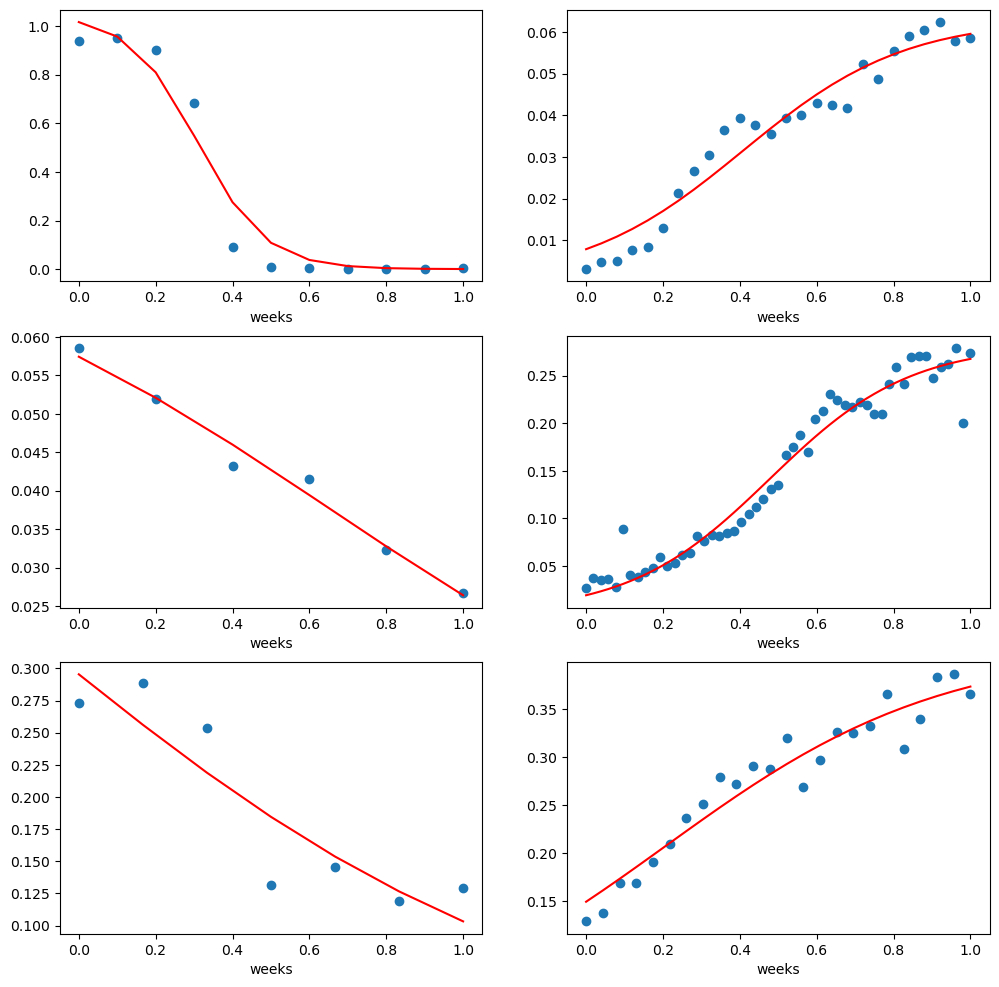

In [298]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict_param1[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict_param1[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict_param1[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict_param1[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict_param1[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict_param1[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

## Predict

In [127]:
cluster_1

[22]

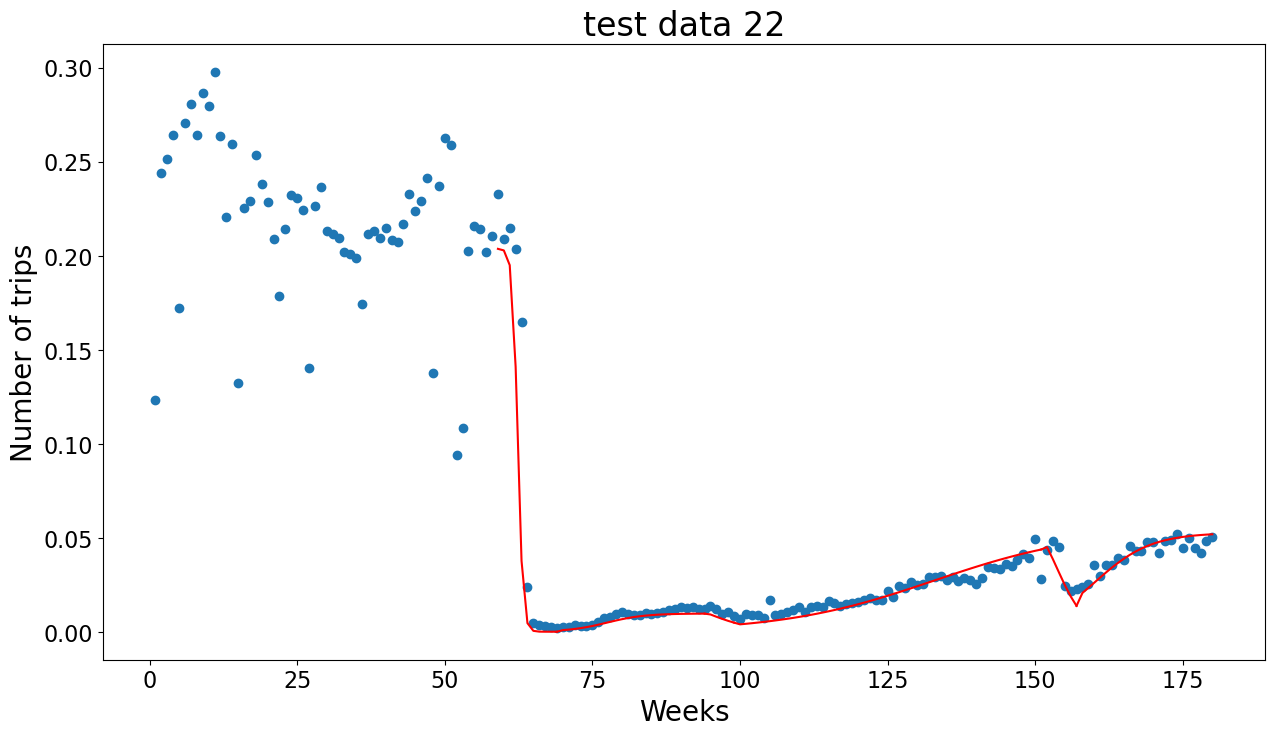

In [532]:
fig, ax = plt.subplots(len(cluster_1),1, figsize=(15,8))
MSE_1=[]
R2_1=[]
for k in range(len(cluster_1)):
    predict1=[]
    pre_1=[]
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        y=data_test[cluster_1[k]][a:b+1]
        pre_y=predict_param1[i]*(np.mean(test_before[cluster_1[k]])-min_trips)+min_trips
        if i>0:
            pre_y[0]=predict1[i-1][-1]
        predict1.append(pre_y)
        pre_1=pre_1+pre_y.detach().numpy().tolist()[:(b-a)]
    MSE=mean_squared_error(data_test[cluster_1[k]][59:180],pre_1)*1e5
    r2=r2_score(data_test[cluster_1[k]][59:180],pre_1)
    MSE_1.append(MSE)
    R2_1.append(r2)
    plt.subplot(len(cluster_1),1,k+1)
    plt.scatter(np.linspace(1, 180,180), data_test[cluster_1[k]][:180],label='real_data')
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        plt.plot(np.linspace(a, b,b-a+1), predict1[i].detach().numpy(),'r')
    plt.xlabel('Weeks',fontsize=20)
    plt.ylabel('Number of trips',fontsize=20)
    plt.title("test data %s"%cluster_1[k],fontsize=24)
    plt.tick_params(labelsize=16)
    plt.savefig('./cluster1_pre.png')

In [531]:
R2_1

[0.923549506297907]

## Cluster2

In [320]:
n=len(model.clusters[2])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[2]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)
    
normality=np.zeros([1,60])
for i in model.clusters[2]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[2]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))

In [321]:
parameter2=[]
predict_param2=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.001)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(20000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter2.append(params)
    predict_param2.append(pre_y)

0
step=0 loss=0.56151
step=1000 loss=0.17029
step=2000 loss=0.02309
step=3000 loss=0.01991
step=4000 loss=0.01840
step=5000 loss=0.01636
step=6000 loss=0.01443
step=7000 loss=0.01248
step=8000 loss=0.01073
step=9000 loss=0.00925
step=10000 loss=0.00801
step=11000 loss=0.00715
step=12000 loss=0.00639
step=13000 loss=0.00573
step=14000 loss=0.00514
step=15000 loss=0.00461
step=16000 loss=0.00424
step=17000 loss=0.00389
step=18000 loss=0.00358
step=19000 loss=0.00329
1
step=0 loss=0.02760
step=1000 loss=0.00406
step=2000 loss=0.00164
step=3000 loss=0.00094
step=4000 loss=0.00063
step=5000 loss=0.00036
step=6000 loss=0.00022
step=7000 loss=0.00013
step=8000 loss=0.00010
step=9000 loss=0.00010
step=10000 loss=0.00009
step=11000 loss=0.00009
step=12000 loss=0.00008
step=13000 loss=0.00006
step=14000 loss=0.00005
step=15000 loss=0.00005
step=16000 loss=0.00004
step=17000 loss=0.00004
step=18000 loss=0.00003
step=19000 loss=0.00003
2
step=0 loss=0.17176
step=1000 loss=0.01993
step=2000 loss=0.

Text(0.5, 0, 'weeks')

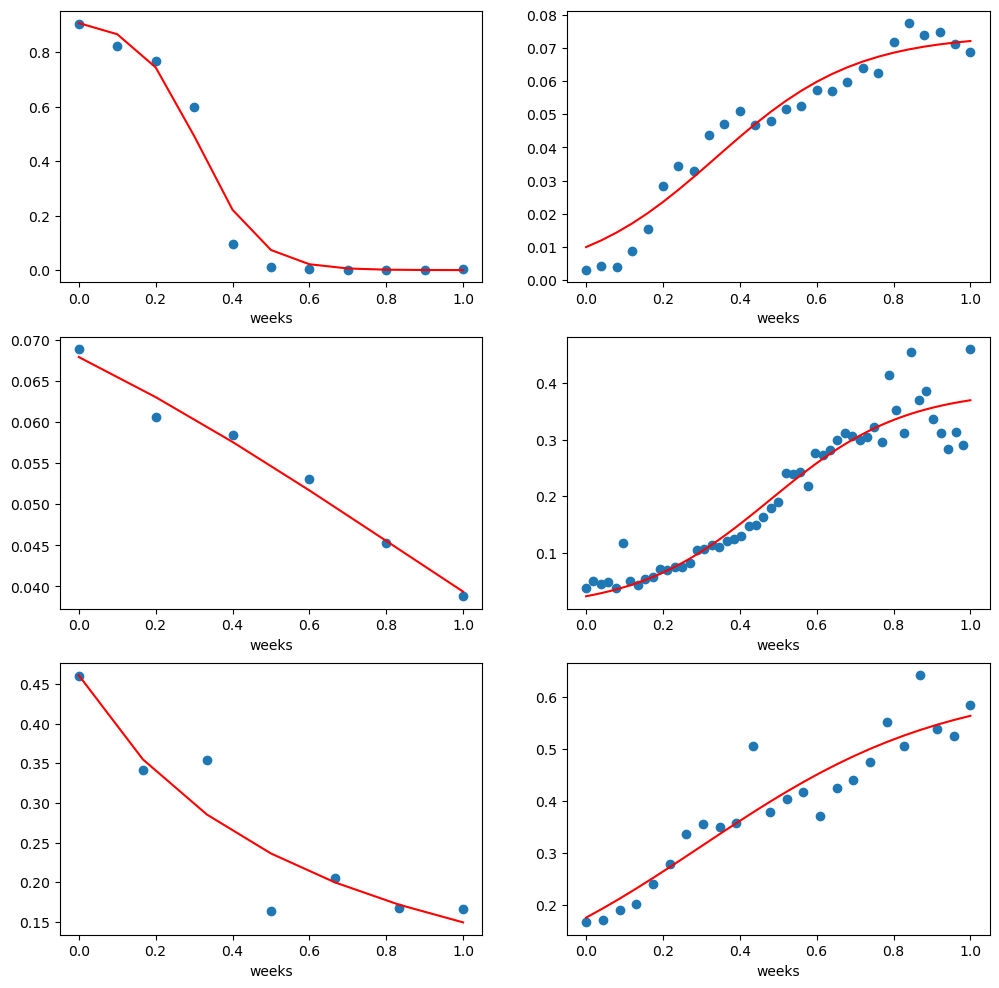

In [322]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict_param2[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict_param2[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict_param2[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict_param2[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict_param2[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict_param2[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

## Predict

In [133]:
cluster_2

[2, 11, 18, 26, 29, 31, 33]

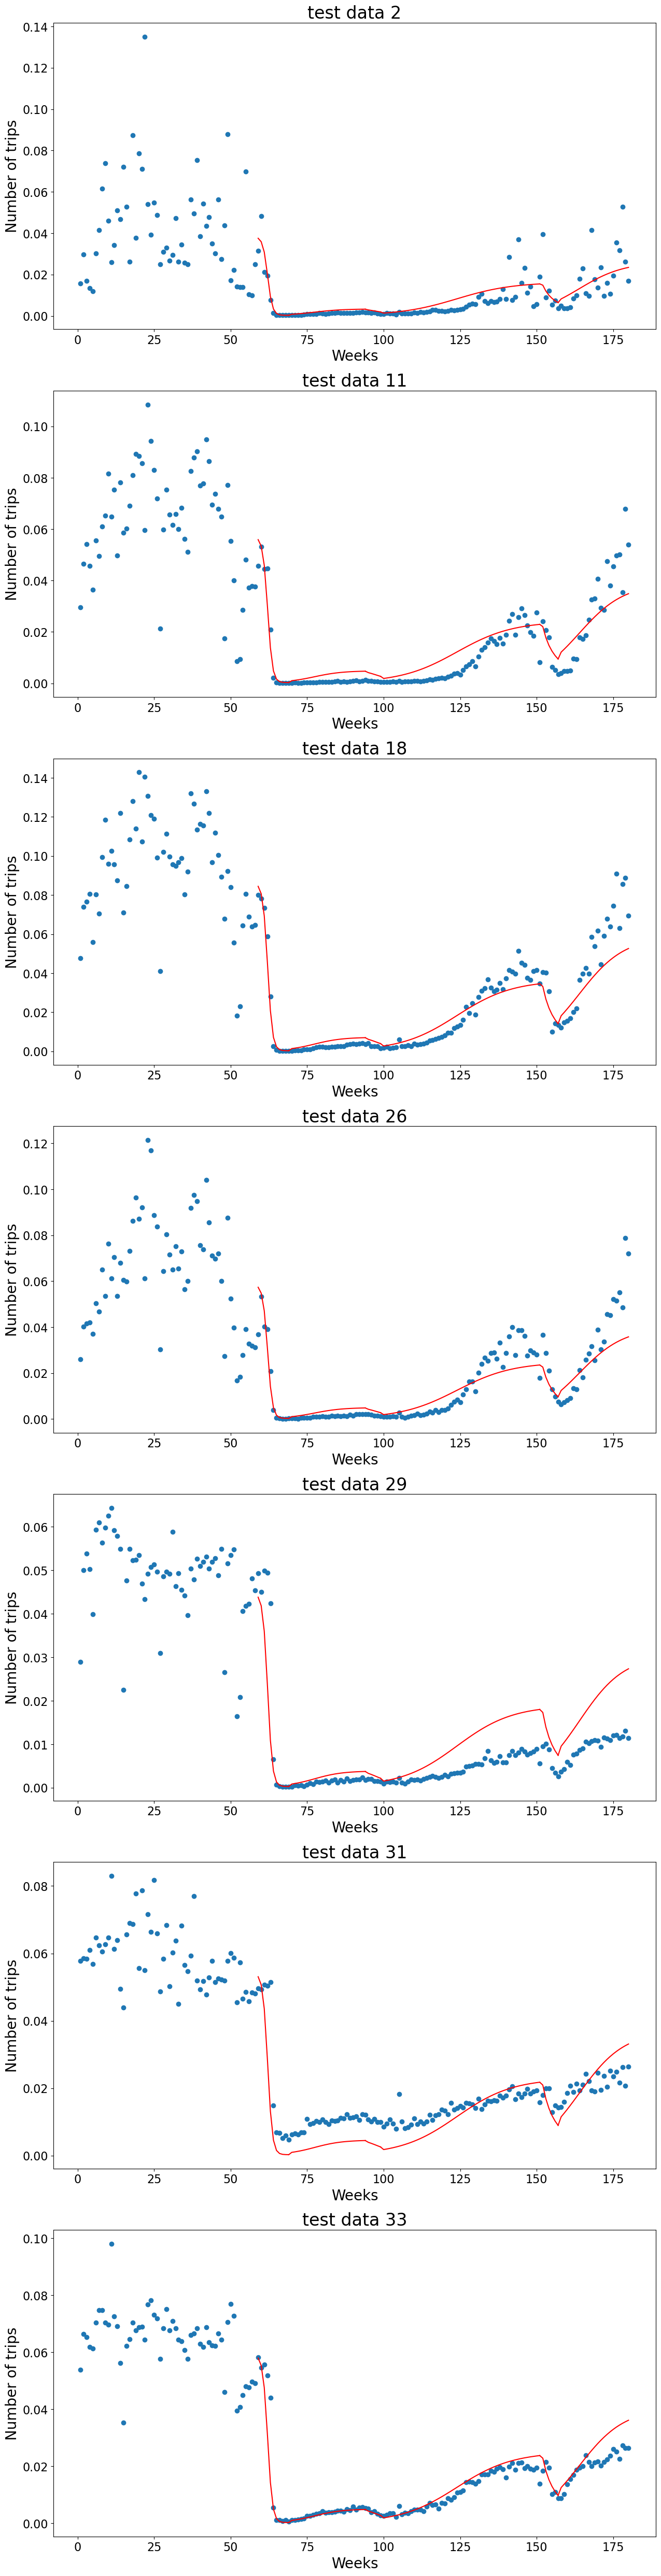

In [540]:
fig, ax = plt.subplots(len(cluster_2),1, figsize=(15,9*len(cluster_2)))
MSE_2=[]
R2_2=[]
for k in range(len(cluster_2)):
    predict2=[]
    pre_2=[]
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        y=data_test[cluster_2[k]][a:b+1]
        pre_y=predict_param2[i]*(np.mean(test_before[cluster_2[k]])-min_trips)+min_trips
        if i>0:
            pre_y[0]=predict2[i-1][-1]
        predict2.append(pre_y)
        pre_2=pre_2+pre_y.detach().numpy().tolist()[:(b-a)]
    MSE=mean_squared_error(data_test[cluster_2[k]][59:180],pre_2)*1e5
    r2=r2_score(data_test[cluster_2[k]][59:180],pre_2)
    MSE_2.append(MSE)
    R2_2.append(r2)
    plt.subplot(len(cluster_2),1,k+1)
    plt.scatter(np.linspace(1, 180,180), data_test[cluster_2[k]][:180],label='real_data')
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        plt.plot(np.linspace(a, b,b-a+1), predict2[i].detach().numpy(),'r')
    plt.xlabel('Weeks',fontsize=20)
    plt.ylabel('Number of trips',fontsize=20)
    plt.title("test data %s"%cluster_2[k],fontsize=24)
    plt.tick_params(labelsize=16)

In [332]:
R2_2

[0.5840139328209114,
 0.7874220916707592,
 0.822049070005644,
 0.7501610886772925,
 0.331390080686202,
 0.5508820013794978,
 0.8908315755143318]

In [140]:
predict12=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[12])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict12[i-1][-1]
    predict12.append(pre_y)

Text(0, 0.5, 'Number of trips')

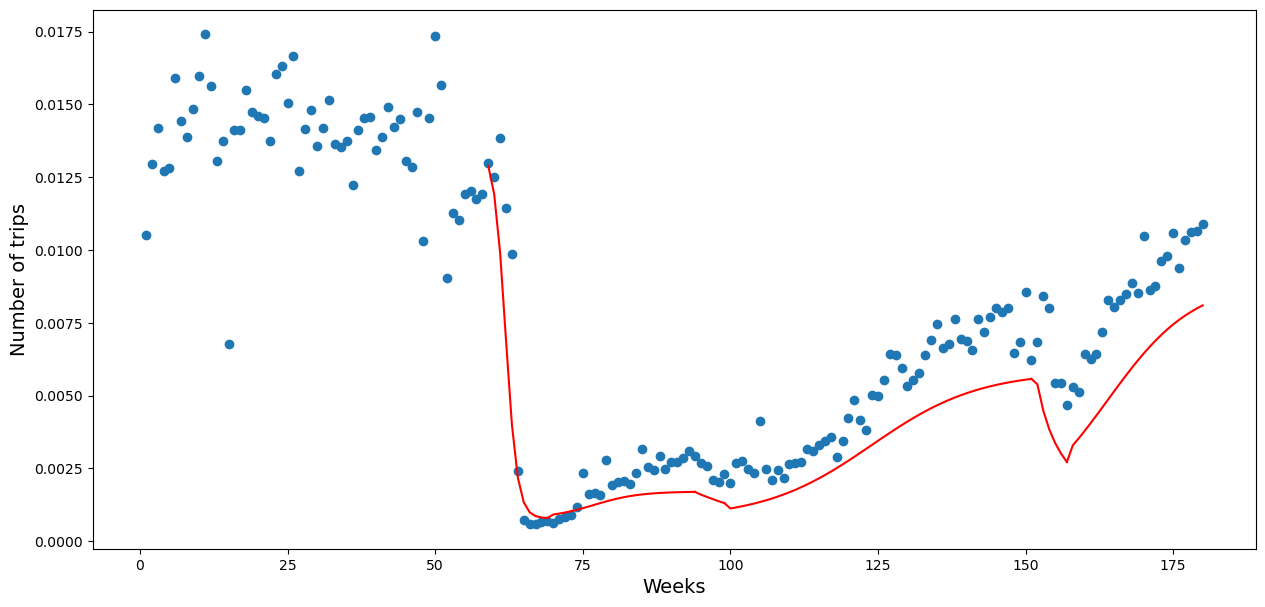

In [141]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[12][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict12[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

In [40]:
predict21=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[21])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict21[i-1][-1]
    predict21.append(pre_y)

Text(0, 0.5, 'Number of trips')

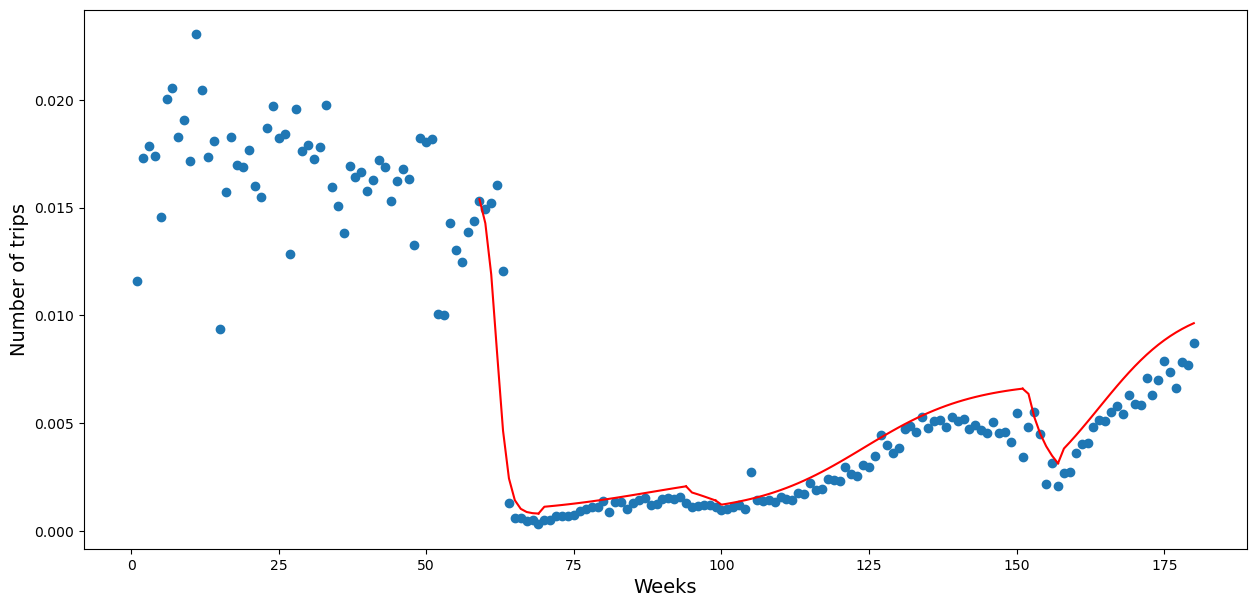

In [41]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[21][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict21[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

## Cluster3

In [388]:
n=len(model.clusters[3])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[3]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)
    
normality=np.zeros([1,60])
for i in model.clusters[3]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[3]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))

In [389]:
parameter3=[]
predict_param3=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.001)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=5000)

    for i in range(20000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter3.append(params)
    predict_param3.append(pre_y)

0
step=0 loss=0.21273
step=1000 loss=0.12721
step=2000 loss=0.03640
step=3000 loss=0.03383
step=4000 loss=0.03040
step=5000 loss=0.02643
step=6000 loss=0.02316
step=7000 loss=0.02009
step=8000 loss=0.01737
step=9000 loss=0.01502
step=10000 loss=0.01299
step=11000 loss=0.01156
step=12000 loss=0.01027
step=13000 loss=0.00913
step=14000 loss=0.00810
step=15000 loss=0.00720
step=16000 loss=0.00654
step=17000 loss=0.00593
step=18000 loss=0.00538
step=19000 loss=0.00487
1
step=0 loss=2.30197
step=1000 loss=0.05171
step=2000 loss=0.00370
step=3000 loss=0.00304
step=4000 loss=0.00296
step=5000 loss=0.00284
step=6000 loss=0.00270
step=7000 loss=0.00250
step=8000 loss=0.00223
step=9000 loss=0.00190
step=10000 loss=0.00150
step=11000 loss=0.00104
step=12000 loss=0.00038
step=13000 loss=0.00034
step=14000 loss=0.00032
step=15000 loss=0.00030
step=16000 loss=0.00028
step=17000 loss=0.00025
step=18000 loss=0.00022
step=19000 loss=0.00020
2
step=0 loss=0.07814
step=1000 loss=0.02196
step=2000 loss=0.

Text(0.5, 0, 'weeks')

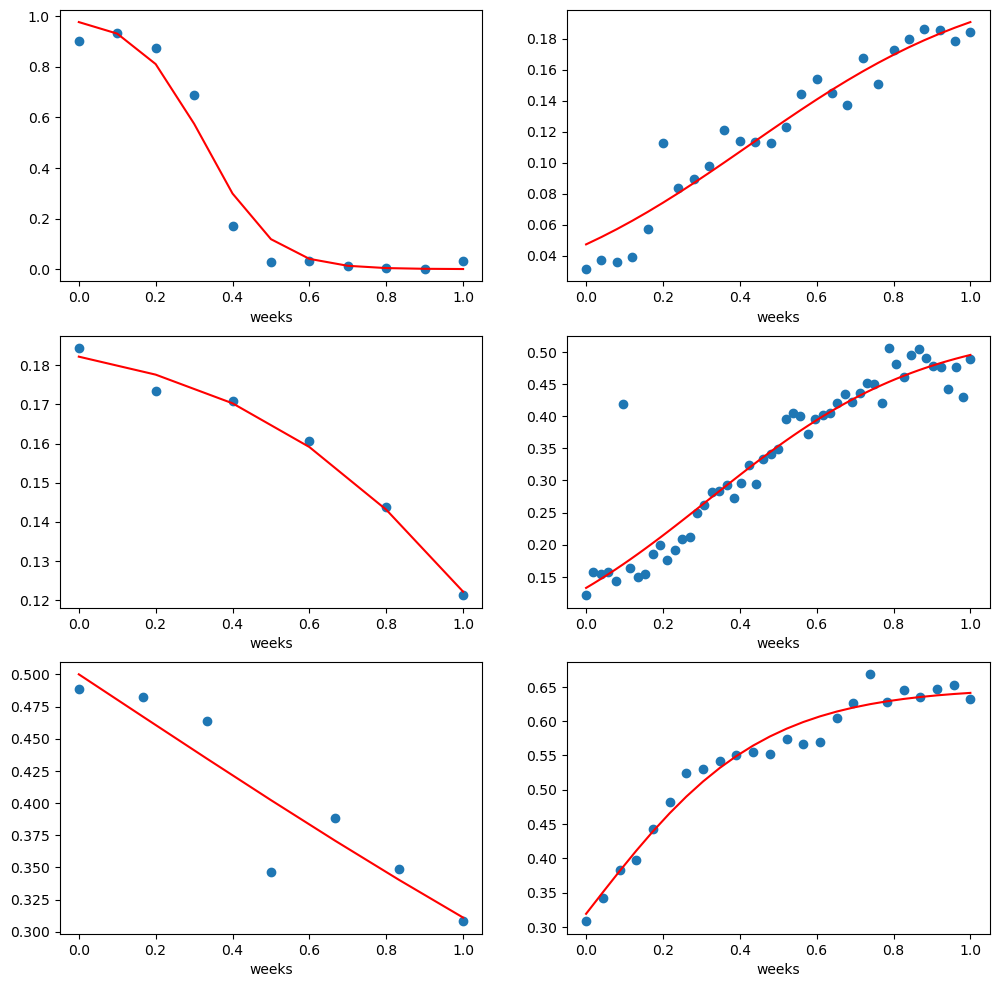

In [390]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict_param3[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict_param3[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict_param3[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict_param3[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict_param3[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict_param3[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

## Predict

In [391]:
cluster_3

[0, 1, 4, 5, 6, 7, 8, 13, 15, 16, 19, 20, 23, 24, 25, 27, 30, 32, 34, 35]

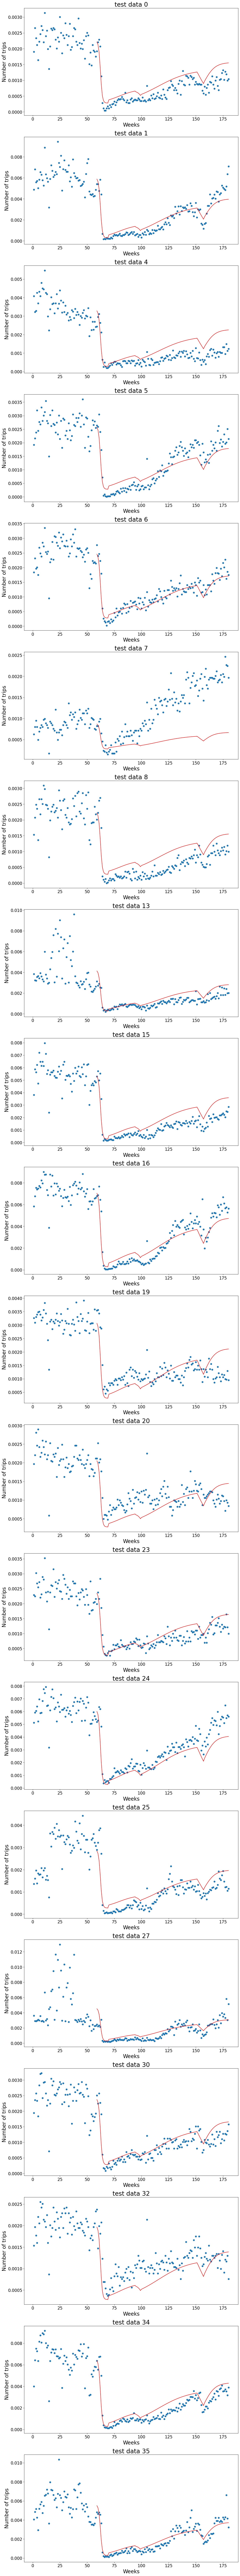

In [543]:
fig, ax = plt.subplots(len(cluster_3),1, figsize=(15,9*len(cluster_3)))
MSE_3=[]
R2_3=[]
for k in range(len(cluster_3)):
    predict3=[]
    pre_3=[]
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        y=data_test[cluster_3[k]][a:b+1]
        pre_y=predict_param3[i]*(np.mean(test_before[cluster_3[k]])-min_trips)+min_trips
        if i>0:
            pre_y[0]=predict3[i-1][-1]
        predict3.append(pre_y)
        pre_3=pre_3+pre_y.detach().numpy().tolist()[:(b-a)]
    MSE=mean_squared_error(data_test[cluster_3[k]][59:180],pre_3)*1e5
    r2=r2_score(data_test[cluster_3[k]][59:180],pre_3)
    MSE_3.append(MSE)
    R2_3.append(r2)
    plt.subplot(len(cluster_3),1,k+1)
    plt.scatter(np.linspace(1, 180,180), data_test[cluster_3[k]][:180],label='real_data')
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        plt.plot(np.linspace(a, b,b-a+1), predict3[i].detach().numpy(),'r')
    plt.xlabel('Weeks',fontsize=20)
    plt.ylabel('Number of trips',fontsize=20)
    plt.title("test data %s"%cluster_3[k],fontsize=24)
    plt.tick_params(labelsize=16)

In [46]:
predict6=[]
min_trips=np.min(data_test[6][60:75])
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[6])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict6[i-1][-1]
    predict6.append(pre_y)

Text(0, 0.5, 'Number of trips')

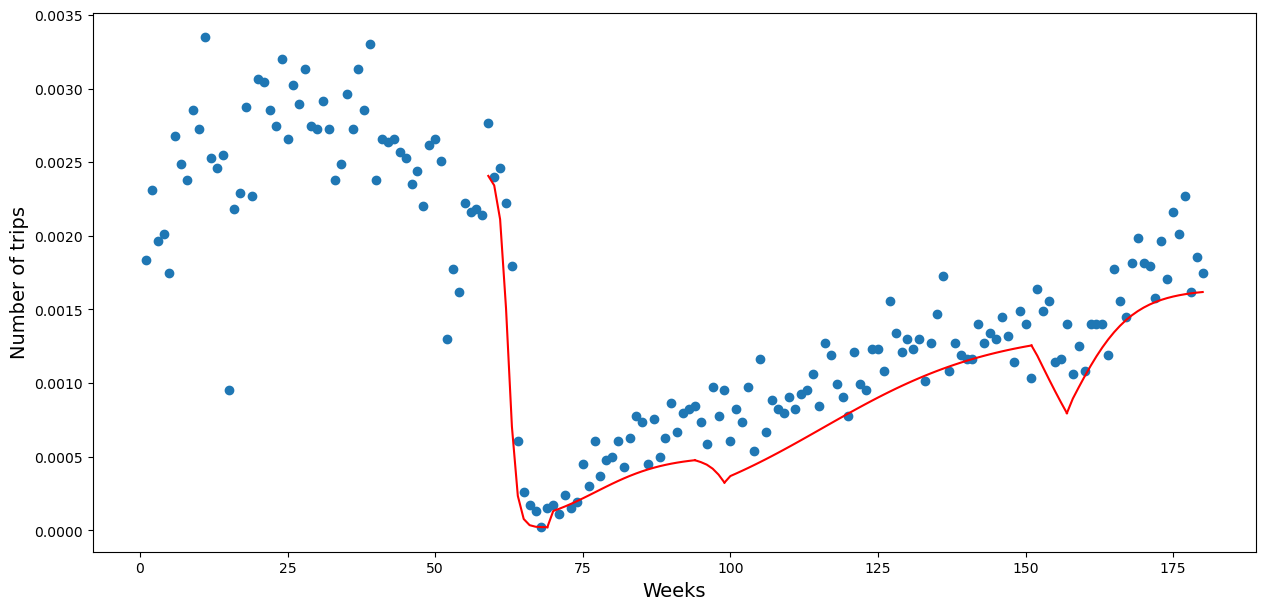

In [47]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[6][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict6[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

In [48]:
predict8=[]
min_trips=np.min(data_test[8][60:75])
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[8])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict8[i-1][-1]
    predict8.append(pre_y)

Text(0, 0.5, 'Number of trips')

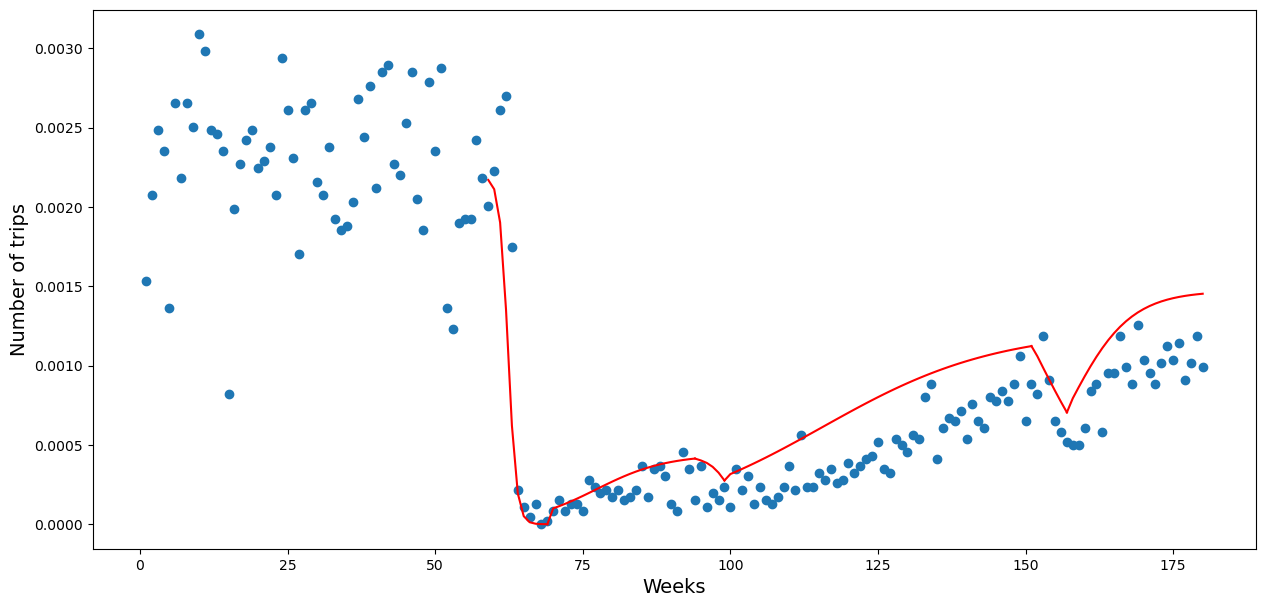

In [49]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[8][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict8[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

## Cluster4

In [355]:
n=len(model.clusters[4])
yorigin=[]
xdays=[]
x_days=[]
ydata=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    sum_y=np.zeros([1,b-a+1])
    days=np.array(np.linspace(a, b,b-a+1))
    for j in model.clusters[4]:
        sum_y=sum_y+data_train[j][a:b+1]
    sum_y=sum_y/n
    yorigin.append(sum_y)
    xdays.append(days)
    x_days.append(days)
    ydata.append(sum_y)
    
normality=np.zeros([1,60])
for i in model.clusters[4]:
    normality=normality+train_before[i]
normality=normality/len(model.clusters[4]) 
min_trips=np.min(yorigin[0]) #bottom of the resilience model (average of all data in cluster 0)
average_normality=np.mean(normality)

for i in range(len(time_interval)):
    ydata[i]=torch.tensor((yorigin[i]-min_trips)/(average_normality-min_trips))
    x_days[i]=torch.tensor((xdays[i]-np.min(xdays[i]))/(np.max(xdays[i])-np.min(xdays[i])))

In [358]:
parameter4=[]
predict_param4=[]
for k in range(len(time_interval)):
    print("%s"%k)
    device="cpu"
    a = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    b = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    c = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    d = torch.nn.Parameter(torch.randn(1,dtype=torch.float64,device=device))
    params=[a,b,c,d]
    optimizer = optim.Adam(params,lr=0.001)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=3000)

    for i in range(15000):
        optimizer.zero_grad()
        predict_y = func(x_days[k],*params)
        loss = torch.mean(torch.pow(ydata[k]-predict_y,2))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if i%1000==0:
            print("step=%s loss=%.5f"%(i,loss))
    pre_y = func(x_days[k],*params)
    parameter4.append(params)
    predict_param4.append(pre_y)

0
step=0 loss=0.70398
step=1000 loss=0.24043
step=2000 loss=0.16030
step=3000 loss=0.10339
step=4000 loss=0.03924
step=5000 loss=0.02902
step=6000 loss=0.02783
step=7000 loss=0.02649
step=8000 loss=0.02459
step=9000 loss=0.02221
step=10000 loss=0.02018
step=11000 loss=0.01824
step=12000 loss=0.01647
step=13000 loss=0.01518
step=14000 loss=0.01400
1
step=0 loss=5.64471
step=1000 loss=0.01754
step=2000 loss=0.00032
step=3000 loss=0.00031
step=4000 loss=0.00031
step=5000 loss=0.00031
step=6000 loss=0.00031
step=7000 loss=0.00031
step=8000 loss=0.00030
step=9000 loss=0.00029
step=10000 loss=0.00029
step=11000 loss=0.00027
step=12000 loss=0.00025
step=13000 loss=0.00022
step=14000 loss=0.00018
2
step=0 loss=0.01921
step=1000 loss=0.00005
step=2000 loss=0.00003
step=3000 loss=0.00003
step=4000 loss=0.00003
step=5000 loss=0.00003
step=6000 loss=0.00003
step=7000 loss=0.00003
step=8000 loss=0.00003
step=9000 loss=0.00003
step=10000 loss=0.00003
step=11000 loss=0.00003
step=12000 loss=0.00003
s

Text(0.5, 0, 'weeks')

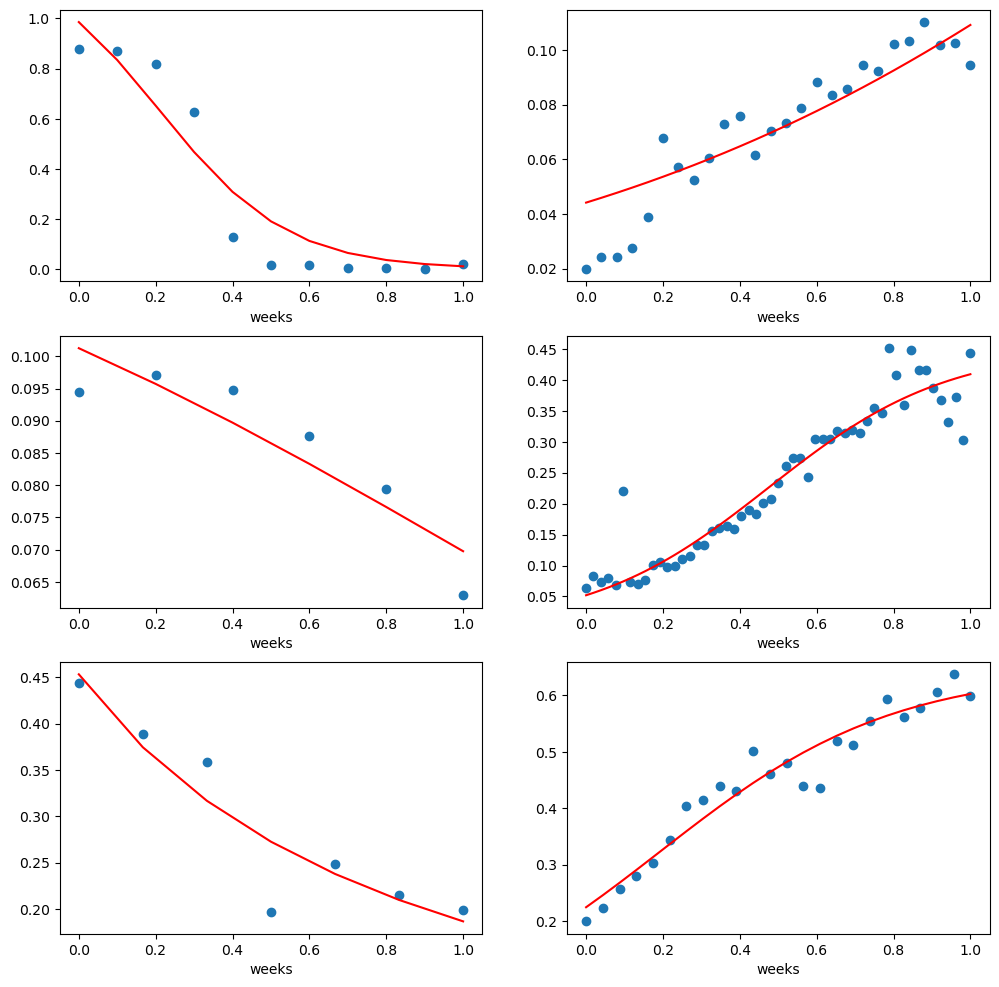

In [359]:
fig, ax = plt.subplots(3,2, figsize=(12,12))
plt.subplot(3,2,1)
plt.scatter(x_days[0], ydata[0], label='[59,70]')
plt.plot(x_days[0], predict_param4[0].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,2)
plt.scatter(x_days[1], ydata[1], label='[70,92]')
plt.plot(x_days[1], predict_param4[1].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,3)
plt.scatter(x_days[2], ydata[2], label='[93,103]')
plt.plot(x_days[2], predict_param4[2].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,4)
plt.scatter(x_days[3], ydata[3], label='[105,150]')
plt.plot(x_days[3], predict_param4[3].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,5)
plt.scatter(x_days[4], ydata[4], label='[151,156]')
plt.plot(x_days[4], predict_param4[4].detach().numpy(), 'r-')
plt.xlabel('weeks')
plt.subplot(3,2,6)
plt.scatter(x_days[5], ydata[5], label='[157,180]')
plt.plot(x_days[5], predict_param4[5].detach().numpy(), 'r-')
plt.xlabel('weeks')

## Predict

In [53]:
cluster_4

[3, 10, 12, 14, 17, 21, 28, 36]

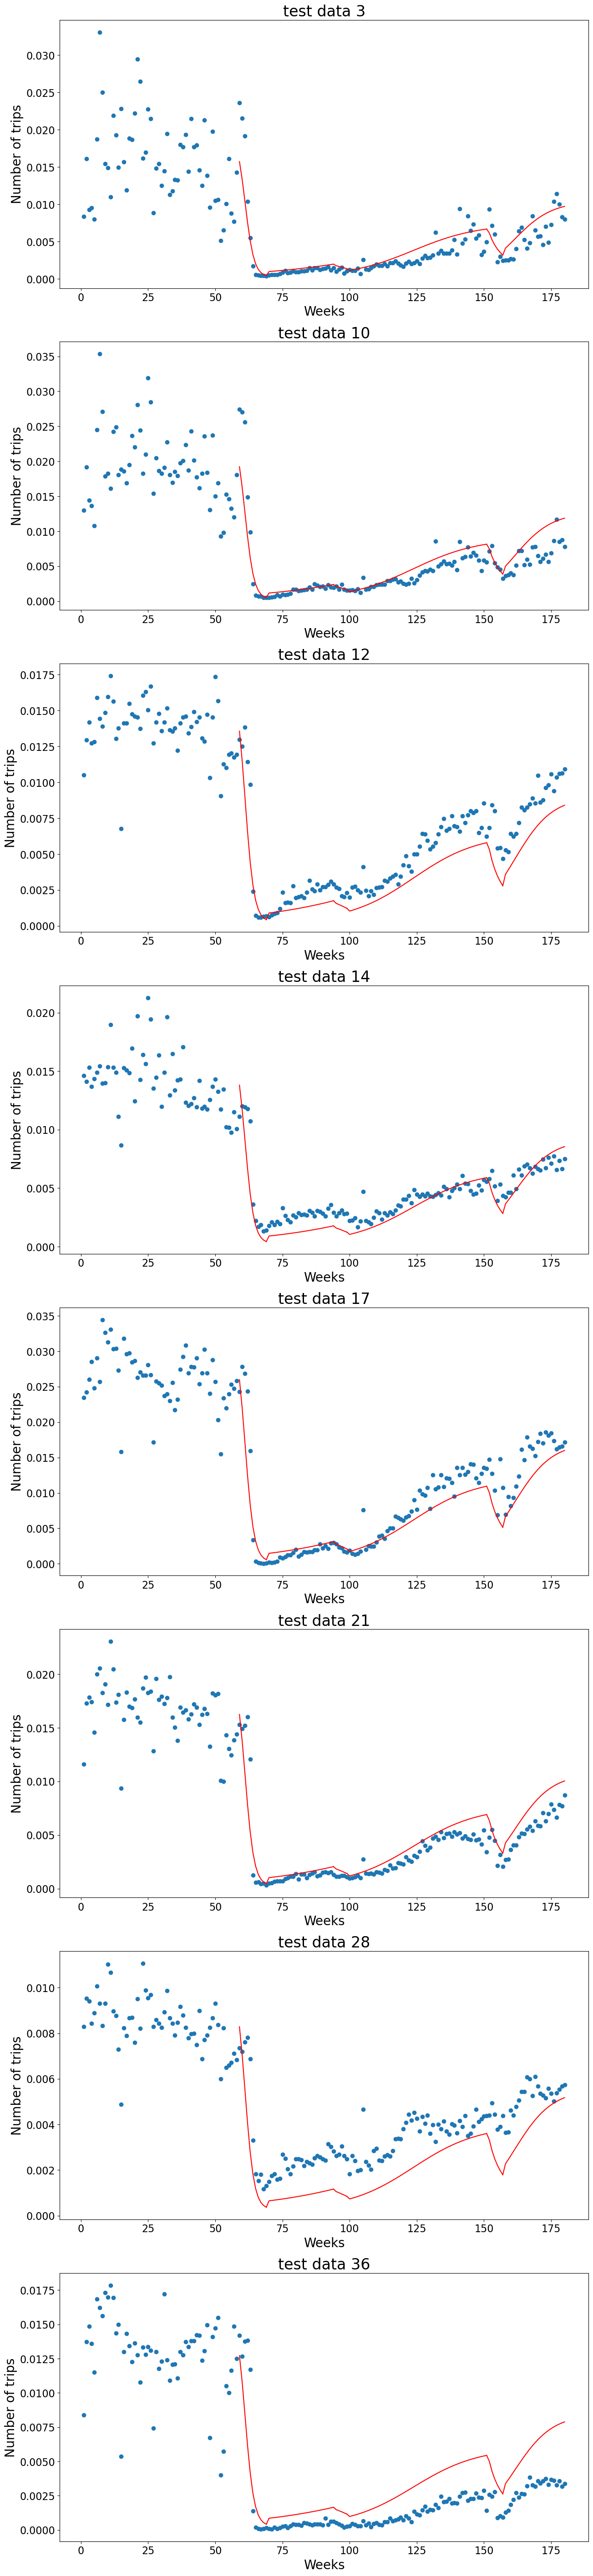

In [544]:
fig, ax = plt.subplots(len(cluster_4),1, figsize=(15,9*len(cluster_4)))
MSE_4=[]
R2_4=[]
for k in range(len(cluster_4)):
    predict4=[]
    pre_4=[]
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        y=data_test[cluster_4[k]][a:b+1]
        pre_y=predict_param4[i]*(np.mean(test_before[cluster_4[k]])-min_trips)+min_trips
        if i>0:
            pre_y[0]=predict4[i-1][-1]
        predict4.append(pre_y)
        pre_4=pre_4+pre_y.detach().numpy().tolist()[:(b-a)]
    MSE=mean_squared_error(data_test[cluster_4[k]][59:180],pre_4)*1e5
    r2=r2_score(data_test[cluster_4[k]][59:180],pre_4)
    MSE_4.append(MSE)
    R2_4.append(r2)
    plt.subplot(len(cluster_4),1,k+1)
    plt.scatter(np.linspace(1, 180,180), data_test[cluster_4[k]][:180],label='real_data')
    for i in range(len(time_interval)):
        a=time_interval[i][0]
        b=time_interval[i][1]
        plt.plot(np.linspace(a, b,b-a+1), predict4[i].detach().numpy(),'r')
    plt.xlabel('Weeks',fontsize=20)
    plt.ylabel('Number of trips',fontsize=20)
    plt.title("test data %s"%cluster_4[k],fontsize=24)
    plt.tick_params(labelsize=16)

In [54]:
predict2=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[2])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict2[i-1][-1]
    predict2.append(pre_y)

Text(0, 0.5, 'Number of trips')

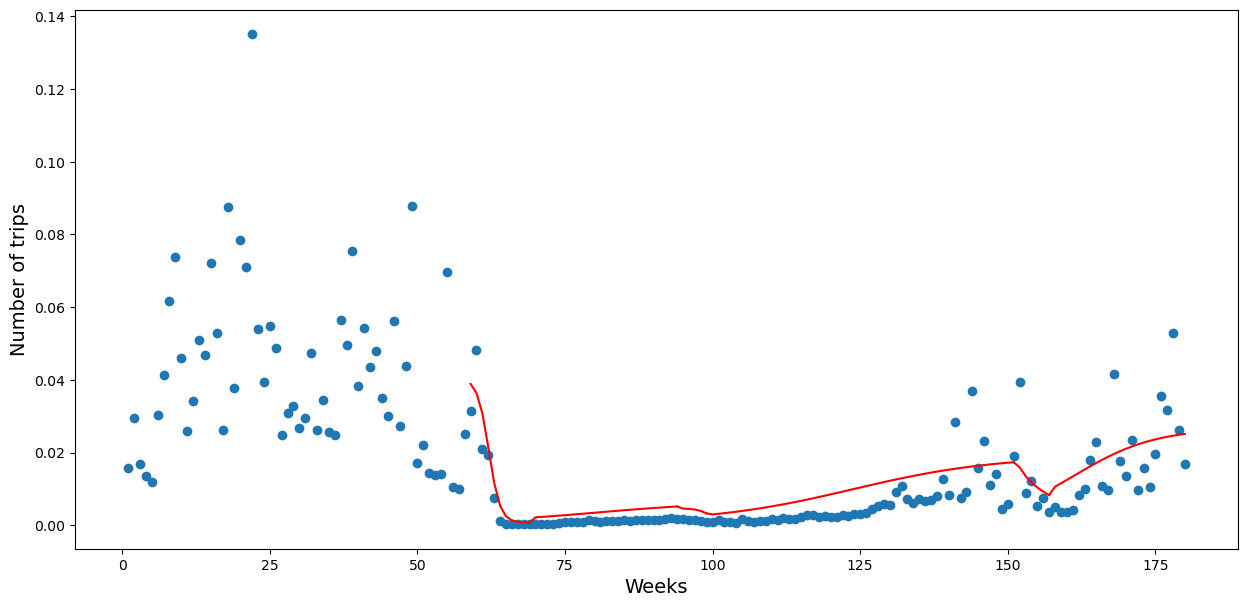

In [55]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[2][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict2[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

In [56]:
predict33=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[33])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict33[i-1][-1]
    predict33.append(pre_y)

Text(0, 0.5, 'Number of trips')

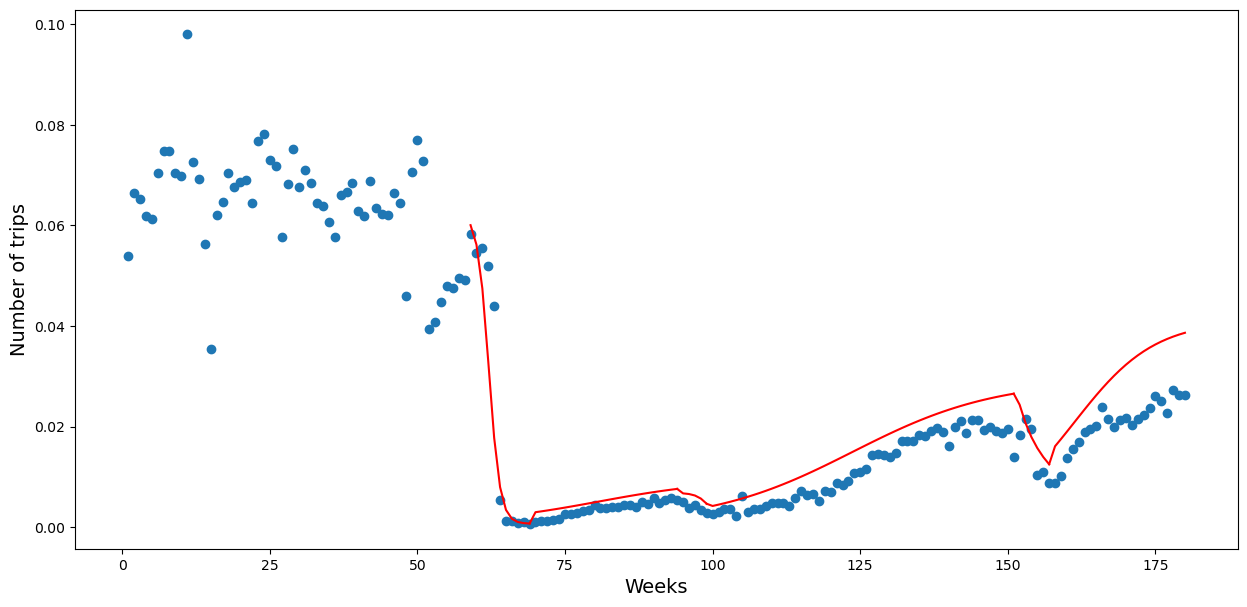

In [57]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[33][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict33[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

In [58]:
predict18=[]
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    pre_y=predict[i]*(np.mean(test_before[18])-min_trips)+min_trips
    if i>0:
        pre_y[0]=predict18[i-1][-1]
    predict18.append(pre_y)

Text(0, 0.5, 'Number of trips')

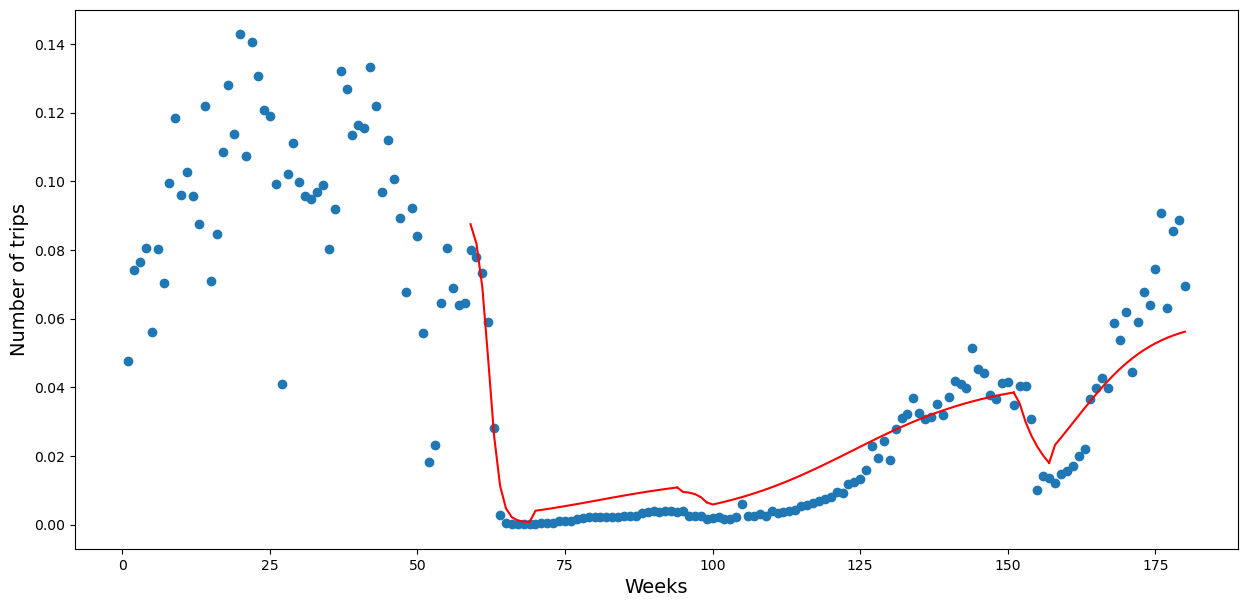

In [59]:
plt.figure(figsize=(15,7))
plt.scatter(np.linspace(1, 180,180), data_test[18][:180],label='real_data')
for i in range(len(time_interval)):
    a=time_interval[i][0]
    b=time_interval[i][1]
    plt.plot(np.linspace(a, b,b-a+1), predict18[i].detach().numpy(),'r')
plt.xlabel('Weeks',fontsize=14)
plt.ylabel('Number of trips',fontsize=14)

### predictive evaluation

In [528]:
recovery_percentage0=[]
recovery_percentage1=[]
recovery_percentage2=[]
recovery_percentage3=[]
recovery_percentage4=[]

for k in range(len(cluster_0)):
    final=np.mean(data_test[cluster_0[k]][180:196])
    normal=np.mean(test_before[cluster_0[k]])
    percent=final/normal
    recovery_percentage0.append(percent)

for k in range(len(cluster_1)):
    final=np.mean(data_test[cluster_1[k]][180:196])
    normal=np.mean(test_before[cluster_1[k]])
    percent=final/normal
    recovery_percentage1.append(percent)
    
for k in range(len(cluster_2)):
    final=np.mean(data_test[cluster_2[k]][180:196])
    normal=np.mean(test_before[cluster_2[k]])
    percent=final/normal
    recovery_percentage2.append(percent)

for k in range(len(cluster_3)):
    final=np.mean(data_test[cluster_3[k]][180:196])
    normal=np.mean(test_before[cluster_3[k]])
    percent=final/normal
    recovery_percentage3.append(percent)

for k in range(len(cluster_4)):
    final=np.mean(data_test[cluster_4[k]][180:196])
    normal=np.mean(test_before[cluster_4[k]])
    percent=final/normal
    recovery_percentage4.append(percent)



In [529]:
centroid_recovery=[]
for centroid in model.centroids:
    final=np.mean(centroid[180:196])
    normal=np.mean(centroid[:50])
    percent=final/normal
    centroid_recovery.append(percent)

In [530]:
from pandas.core.frame import DataFrame
recovery=[]
cluster_index=["cluster 0"]+cluster_0+[" "]+["cluster 1"]+cluster_1+[" "]+["cluster 2"]+cluster_2+[" "]+["cluster 3"]+cluster_3+[" "]+["cluster 4"]+cluster_4
recovery=[centroid_recovery[0]]+recovery_percentage0+[" "]+[centroid_recovery[1]]+recovery_percentage1+[" "]+[centroid_recovery[2]]+recovery_percentage2+[" "]+[centroid_recovery[3]]+recovery_percentage3+[" "]+[centroid_recovery[4]]+recovery_percentage4
MSE=[" "]+MSE_0+[" "]+[" "]+MSE_1+[" "]+[" "]+MSE_2+[" "]+[" "]+MSE_3+[" "]+[" "]+MSE_4
R2=[" "]+R2_0+[" "]+[" "]+R2_1+[" "]+[" "]+R2_2+[" "]+[" "]+R2_3+[" "]+[" "]+R2_4

df={"testdata_index": cluster_index,
    "recovery":recovery,
    "MSE [1e-5]":MSE,
    "R2":R2
   }
df_recovery=DataFrame(df)
print(df_recovery)

   testdata_index  recovery MSE [1e-5]        R2
0       cluster 0  0.230556                     
1               9  0.297815    2.49106  0.979269
2                                               
3       cluster 1  0.350174                     
4              22  0.229125  93.016242   0.92355
5                                               
6       cluster 2   0.47915                     
7               2  0.608908   4.565771  0.585951
8              11  0.661561   4.876446  0.788934
9              18  0.737674   9.815139   0.82196
10             26  0.750525   7.463568  0.750041
11             29   0.22926   4.612425   0.33982
12             31  0.363738   3.087766  0.544265
13             33  0.357373   1.217598  0.892453
14                                              
15      cluster 3  0.607259                     
16              0   0.44704   0.009253  0.414931
17              1  0.883131   0.050416  0.813772
18              4  0.282245   0.040429 -0.891763
19              5  0

In [495]:
df_recovery.to_csv('MSE.csv')